In [1]:
# This code can be downloaded as a Python script and run as:
# python full_vs_EM_any_dataset.py random_state dataset_name test_proportion val_proportion M_method M_alpha M_beta
#     test_proportion: The test proportion is from all the available true labels
#     val_proportion: The validation proportion is from the remaining training proportion with the true labels

def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

import sys
import matplotlib

if is_interactive():
    %matplotlib inline
    sys.path.append('../')
    random_state = 0
    dataset_name = 'blobs'
    prop_test = 0.9
    prop_val = 0.5
    M_method = 'noisy' # IPL, quasi_IPL, random_weak, random_noise, noisy, supervisedg
    M_alpha = 0.6 # Alpha = 1.0 No unsupervised in IPL
    M_beta = 0.1 # Beta = 0.0 No noise
    data_folder = '../data/'
    max_epochs = 2000
else:
    matplotlib.use('Agg')
    random_state = int(sys.argv[1])
    dataset_name = sys.argv[2]
    prop_test = float(sys.argv[3])
    prop_val = float(sys.argv[4])
    max_epochs = int(sys.argv[5])
    if len(sys.argv) > 6:
        M_method = sys.argv[6]
        M_alpha = float(sys.argv[7])
        if len(sys.argv) > 8:
            M_beta = float(sys.argv[8])
        else:
            M_beta = 1 - M_alpha
    data_folder = './data/'
    print(locals())

import numpy
from experiments.data import make_weak_true_partition
from wlc.WLweakener import computeM, weak_to_index, estimate_M
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from experiments.models import create_model, MyKerasClassifier
import inspect
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from matplotlib import cm

from experiments.visualizations import plot_heatmap
from experiments.visualizations import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.dpi"] = 100

cmap = cm.get_cmap('Accent')

from cycler import cycler
default_cycler = (cycler(color=['darkred', 'forestgreen', 'darkblue', 'violet', 'darkorange', 'saddlebrown']) +
                  cycler(linestyle=['-', '--', '-.', '-', '--', '-.']) + 
                  cycler(marker=['o', 'v', 'x', '*', '+', '.']) +
                  cycler(lw=[2, 1.8, 1.6, 1.4, 1.2, 1]))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

from sklearn.metrics import mean_squared_error
from keras import backend

_EPSILON = backend.epsilon()

def log_loss_np(y_true, y_pred):
    y_pred = numpy.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -y_true * numpy.log(y_pred)
    return numpy.mean(out, axis=-1)

def EM_log_loss_np(y_true, y_pred):
    y_pred = numpy.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    Q = y_true * y_pred
    Z_em_train = Q / Q.sum(axis=-1, keepdims=True)
    out = -Z_em_train*numpy.log(y_pred)
    out = numpy.mean(out, axis=-1)
    return out


def print_performance(model, X, Y):
    for key, perf_func in (('EM', lambda x, y: numpy.mean(EM_log_loss_np(x, y))),
                           ('CE', lambda x, y: numpy.mean(log_loss_np(x, y))),
                           ('MSE', mean_squared_error),
                           ('Acc.', lambda x, y: numpy.mean(numpy.argmax(x, axis=1) == numpy.argmax(y, axis=1)))):
        print('{} = {}'.format(key, perf_func(model.predict_proba(X), Y)))

Using TensorFlow backend.


# 1.a. Load data

The following data may contain weak, true labels or both ($S_w$, $S_t$ and $S_wt$ respectively).

- **PLEASE NOTE**: The current assumption is that the data is originally completly clean, or weak and weak+clean. But there is no current data with weak, weak+clean and clean. If at any point we have an example of that case we will need to rethinkg part of **Section 1**.

In [2]:
numpy.random.seed(random_state)

from sklearn.datasets import make_classification, make_blobs, load_digits
from experiments.data import load_webs, load_labelme, load_mnist, load_cifar10
from experiments.data import load_dataset_apply_model
from sklearn.naive_bayes import GaussianNB
    
n_samples = 5000
n_features = 20
n_classes = 3
true_size = 0.4
only_weak = ()
weak_and_true = ()
only_true = ()

if dataset_name == 'digits':
    true_size = 0.1
    X_t, y_t = load_digits(return_X_y=True)
    n_classes = 10
    true_size = 0.4
    classes = list(range(n_classes))
    n_features = X_t.shape[1]
    only_true = (X_t, y_t)
elif dataset_name == 'blobs':
    n_classes = 4
    classes = list(range(n_classes))
    n_samples = 10000
    true_size = 0.3
    n_features = 30
    centers = numpy.random.rand(n_classes, n_features)*n_features
    cluster_std = numpy.abs(numpy.random.randn(n_classes)*n_features)
    X_t, y_t = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                      cluster_std=cluster_std, random_state=random_state)
    only_true = (X_t, y_t)
elif dataset_name == 'make_classification':
    n_classes = 6
    classes = list(range(n_classes))
    n_samples = 20000
    true_size = 0.3
    n_features = 60
    n_redundant = 0
    n_clusters_per_class = 1
    n_informative = n_features
    X_t, y_t = make_classification(n_samples=n_samples, n_features=n_features,
                               n_classes=n_classes, random_state=random_state,
                               n_redundant=n_redundant,
                               n_informative=n_informative,
                               n_clusters_per_class=n_clusters_per_class)
    only_true = (X_t, y_t)
elif dataset_name == 'quasi_separable':
    
    means = [[-1, 0],
             [-1, 1],
             [ 1, 1]]
    n_classes = len(means)
    classes = list(range(n_classes))
    std = 1.0
    priors = numpy.array([1/3, 1/3, 1/3])
    samples_per_class = (n_samples*priors).astype(int)
    X_t, y_t = make_blobs(n_samples=samples_per_class, n_features=n_features, centers=means,
                      cluster_std=std, random_state=random_state)
    only_true = (X_t, y_t)
    n_features = X_t.shape[1]
elif dataset_name == 'separable':
    
    means = [[-1, 0],
             [-1, 1],
             [ 1, 1]]
    n_classes = len(means)
    classes = list(range(n_classes))
    std = .5
    priors = numpy.array([1/3, 1/3, 1/3])
    samples_per_class = (n_samples*priors).astype(int)
    X_t, y_t = make_blobs(n_samples=samples_per_class, n_features=n_features, centers=means,
                      cluster_std=std, random_state=random_state)
    only_true = (X_t, y_t)
    n_features = X_t.shape[1]
elif dataset_name == 'non_separable':
    std = 2.0
    n_features = 5
    X_t, y_t =  make_blobs(n_samples=n_samples, n_features=n_features, centers=12,
                           cluster_std=std, random_state=random_state)
    y_t[y_t < 5] = 0
    y_t[y_t > 7] = 1
    y_t[y_t > 1] = 2
    only_true = (X_t, y_t)
    n_classes = 3
    n_samples = X_t.shape[0]
elif dataset_name == 'webs':
    only_weak, weak_and_true, only_true, classes = load_webs(tfidf=True, standardize=True,
                                                #categories=['blog', 'inmo', 'parking', 'b2c', 'no_b2c', 'Other'],
                                                categories=['parking', 'b2c', 'no_b2c', 'Other'],
                                                random_state=random_state,
                                                folder=data_folder)
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
elif dataset_name == 'labelme':
    only_weak, weak_and_true, only_true, classes = load_labelme(
                                                random_state=random_state,
                                                folder=data_folder,
                                                keep_valid_test=False,
                                                prop_test=prop_test,
                                                prop_valid=prop_val)
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    X_t, Y_t, y_t = only_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
elif dataset_name == 'iris_lr':
    
    only_weak, weak_and_true, only_true, classes = load_dataset_apply_model(dataset='iris', 
                                                                           true_proportion=0.3,
                                                                           clf=GaussianNB())
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
elif dataset_name == 'digits_lr':
    only_weak, weak_and_true, only_true, classes = load_dataset_apply_model(dataset='digits', 
                                                                           true_proportion=0.3,
                                                                           clf=GaussianNB())
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
elif dataset_name == 'mnist':
    X_t, y_t = load_mnist(random_state=random_state)
    X_t = X_t.reshape(X_t.shape[0], -1)
    print(y_t.shape)
    only_true = (X_t, y_t)
    n_classes = 10
    classes = list(range(n_classes))
    n_features = X_t.shape[1]
elif dataset_name == 'cifar10':
    X_t, y_t = load_cifar10(random_state=random_state)
    X_t = X_t.reshape(X_t.shape[0], -1)
    y_t = y_t.reshape(-1, )
    only_true = (X_t, y_t)
    n_classes = 10
    classes = list(range(n_classes))
    n_features = X_t.shape[-1]
else:
    raise KeyError('Dataset {} not available'.format(dataset_name))

n_only_weak = 0 if not only_weak else only_weak[0].shape[0]
n_weak_and_true = 0 if not weak_and_true else weak_and_true[0].shape[0]
n_only_true = 0 if not only_true else only_true[0].shape[0]

n_samples = n_only_weak + n_weak_and_true + n_only_true

print('Number of features = {}'.format(n_features))
print('Number of classes = {}'.format(n_classes))
print('Class names = {}'.format(classes))
print('Samples with only weak labels = {}'.format(n_only_weak))
print('Samples with weak and true labels = {}'.format(n_weak_and_true))
print('Samples with only true labels = {}'.format(n_only_true))

Number of features = 30
Number of classes = 4
Class names = [0, 1, 2, 3]
Samples with only weak labels = 0
Samples with weak and true labels = 0
Samples with only true labels = 10000


# 1.b. Create synthetic weak labels if required

If the dataset does not have weak labels we will generate a random mixing matrix and generate weak labels for some of the samples.

In [3]:
if not only_weak and not weak_and_true:
    if M_method != 'IPL':
        M_alpha = 1.0

    M = computeM(n_classes, method=M_method, alpha=M_alpha, beta=M_beta,
                 seed=random_state)

    print(numpy.round(M, decimals=3))
    
    only_weak, weak_and_true, only_true, classes = make_weak_true_partition(M, X_t, y_t,
                                                                            true_size=true_size,
                                                                            random_state=random_state)

    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
else:
    M_method = None
    M_alpha = None
    M_beta = None
    M = estimate_M(Z_wt, Y_wt, range(n_classes), reg='Partial', Z_reg=Z_w)

n_w_samples = 0 if not only_weak else only_weak[0].shape[0]
n_wt_samples = 0 if not weak_and_true else weak_and_true[0].shape[0]
n_t_samples = 0 if not only_true else only_true[0].shape[0]
print('Samples with only weak labels = {}'.format(n_w_samples))
print('Samples with weak and true labels = {}'.format(n_wt_samples))
print('Samples with only true labels = {}'.format(n_t_samples))
print('Class priors \n{}'.format(Y_wt.mean(axis=0)))

[[0.9   0.033 0.033 0.033]
 [0.033 0.9   0.033 0.033]
 [0.033 0.033 0.9   0.033]
 [0.033 0.033 0.033 0.9  ]]
Samples with only weak labels = 7000
Samples with weak and true labels = 3000
Samples with only true labels = 0
Class priors 
[0.25 0.25 0.25 0.25]


# 1.c. Show weak and true samples

In the following plots we show only the 2 features with most variance on every set

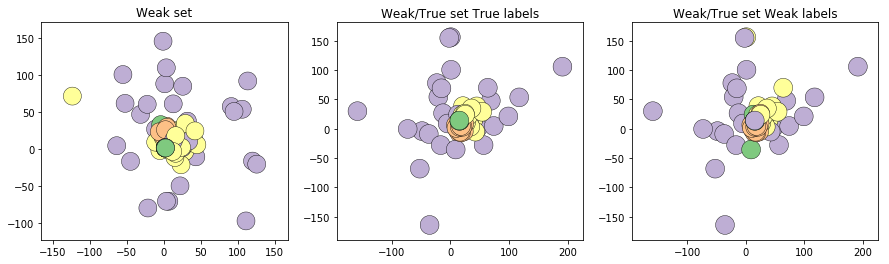

In [4]:
from experiments.visualizations import plot_multilabel_scatter

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
_ = plot_multilabel_scatter(X_w[:100, ], Z_w[:100], fig=fig,
                            ax=ax, title='Weak set', cmap=cmap)
ax = fig.add_subplot(1, 3, 2)
_ = plot_multilabel_scatter(X_wt[:100], Y_wt[:100], fig=fig,
                            ax=ax, title='Weak/True set True labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 3)
_ = plot_multilabel_scatter(X_wt[:100], Z_wt[:100], fig=fig,
                            ax=ax, title='Weak/True set Weak labels', cmap=cmap)

# 1.d. Save true labels for validation and for testing

If there is a set with only true labels, it is ussed always as a test set only (not validation)

In [5]:
# prop_test is defined in the arguments

sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                             train_size=(1. - prop_test),
                             test_size=prop_test)

train_indx, test_indx = next(sss.split(X_wt, y_wt))
n_wt_samples = len(z_wt)
print('Weak and true labels: Original partition size = {}'.format(n_wt_samples))

# train partition
X_wt_train, Z_wt_train, z_wt_train = X_wt[train_indx], Z_wt[train_indx], z_wt[train_indx]
Y_wt_train, y_wt_train = Y_wt[train_indx], y_wt[train_indx]
# test partition
X_wt_test, Z_wt_test, z_test = X_wt[test_indx], Z_wt[test_indx], z_wt[test_indx]
Y_wt_test, y_wt_test = Y_wt[test_indx], y_wt[test_indx]

if n_t_samples != 0:
    X_wt_test = numpy.concatenate((X_wt_test, X_t))
    Y_wt_test = numpy.concatenate((Y_wt_test, Y_t))
    y_wt_test = numpy.concatenate((y_wt_test, y_t))


# We will use half of the train data for validation
sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                             train_size=(1. - prop_val),
                             test_size=prop_val)

train_indx, val_indx = next(sss.split(X_wt_train, y_wt_train))
# Validation partition
X_wt_val, Z_wt_val, z_wt_val = X_wt_train[val_indx], Z_wt_train[val_indx], z_wt_train[val_indx]
Y_wt_val, y_wt_val = Y_wt_train[val_indx], y_wt_train[val_indx]
# train partition
X_wt_train, Z_wt_train, z_wt_train = X_wt_train[train_indx], Z_wt_train[train_indx], z_wt_train[train_indx]
Y_wt_train, y_wt_train = Y_wt_train[train_indx], y_wt_train[train_indx]


n_wt_samples_train = len(y_wt_train)
n_wt_samples_val = len(y_wt_val)
n_wt_samples_test = len(y_wt_test)
print('Weak and true labels for training partition size = {}'.format(n_wt_samples_train))
print('True labels for validation partition size = {}'.format(n_wt_samples_val))
print('True labels for test partition size = {}'.format(n_wt_samples_test))

Weak and true labels: Original partition size = 3000
Weak and true labels for training partition size = 149
True labels for validation partition size = 150
True labels for test partition size = 2700


# 2.a. Train Scikit learn baselines

## 2.a.1. Upperbound if we have access to the full true labels

- This trains with all the following partitions
    - $S_w$
    - $S_{wt.train}$
    - $S_{wt.val}$

A Logistic Regression trained with all the real labels (7299 samples)
Accuracy = 0.8970370370370371


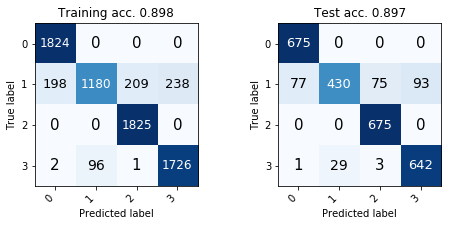

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [6]:
if y_w is not None:
    X_aux_train = numpy.concatenate((X_w, X_wt_train, X_wt_val))
    y_aux_train = numpy.concatenate((y_w, y_wt_train, y_wt_val))
    LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs, penalty='l2', C=0.01)
    LR.fit(X_aux_train, y_aux_train)
    print('A Logistic Regression trained with all the real labels ({} samples)'.format(y_aux_train.shape[0]))
    acc_upperbound = LR.score(X_wt_test, y_wt_test)
    print('Accuracy = {}'.format(acc_upperbound))

    fig = plt.figure(figsize=(8,3))
    clf_pred =  LR.predict(X_aux_train)
    cm = confusion_matrix(y_aux_train, clf_pred)
    acc = (y_aux_train == clf_pred).mean()
    ax = fig.add_subplot(1, 2, 1)
    _ = plot_confusion_matrix(cm, ax=ax, title='Training acc. {:.3}'.format(acc))

    clf_pred =  LR.predict(X_wt_test)
    cm = confusion_matrix(y_wt_test, clf_pred)
    acc = (y_wt_test == clf_pred).mean()
    ax = fig.add_subplot(1, 2, 2)
    _ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

## 2.a.2. Lowerbound if we have access to a limited set of true labels


- This trains with all the following partitions
    - $S_{wt.train}$
    - $S_{wt.val}$

A Logistic Regression trained with all the real labels (299 samples)
Accuracy = 0.8759259259259259


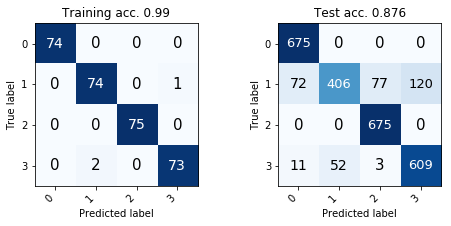

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [7]:
X_aux_train = numpy.concatenate((X_wt_train, X_wt_val))
y_aux_train = numpy.concatenate((y_wt_train, y_wt_val))
LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs, penalty='l2', C=0.01)
LR.fit(X_aux_train, y_aux_train)
print('A Logistic Regression trained with all the real labels ({} samples)'.format(y_aux_train.shape[0]))
acc_upperbound = LR.score(X_wt_test, y_wt_test)
print('Accuracy = {}'.format(acc_upperbound))

fig = plt.figure(figsize=(8,3))
clf_pred =  LR.predict(X_aux_train)
cm = confusion_matrix(y_aux_train, clf_pred)
acc = (y_aux_train == clf_pred).mean()
ax = fig.add_subplot(1, 2, 1)
_ = plot_confusion_matrix(cm, ax=ax, title='Training acc. {:.3}'.format(acc))

clf_pred =  LR.predict(X_wt_test)
cm = confusion_matrix(y_wt_test, clf_pred)
acc = (y_wt_test == clf_pred).mean()
ax = fig.add_subplot(1, 2, 2)
_ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

# 2.b. Train Keras baselines

**TODO: check what happens when there is a typo on the early_stop_loss**


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras import regularizers

_EPSILON = K.epsilon()

def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -y_true*K.log(y_pred)
    return K.mean(out, axis=-1)

def make_model_lr(loss):
    model = Sequential() 
    model.add(Dense(n_classes, input_dim=n_features, activation='softmax'))
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    print('Sample of first weights = {}'.format(numpy.round(model.get_weights()[0][0], decimals=3)))
    return model

def make_model_mlp(loss):
    model = Sequential() 
    model.add(Dense(20, input_dim=n_features))
    model.add(Dense(20))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    print('Sample of first weights = {}'.format(numpy.round(model.get_weights()[0][0], decimals=3)))
    return model

make_model = make_model_lr

from keras.callbacks import EarlyStopping

batch_size = None
patience = int(max_epochs/6)
early_stop_loss = 'val_categorical_crossentropy' # TODO Check what happens when there is a typo in this loss

early_stopping = EarlyStopping(monitor=early_stop_loss, min_delta=0, patience=patience, 
                               verbose=2, mode='auto', baseline=None,
                               restore_best_weights=True)

def plot_results(model, X_test, y_test, history):
    if not is_interactive():
        return
    
    clf_proba_wt_test = model.predict_proba(X_test)
    clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
    cm = confusion_matrix(y_test, clf_pred_wt_test)

        
    def show_best(ax, history, field, best_min = True):
        if best_min:
            best_epoch = numpy.argmin(history.history[field])
        else:
            best_epoch = numpy.argmax(history.history[field])
        _ = ax.scatter(best_epoch, history.history[field][best_epoch],
                       color='white', edgecolor='black', marker='*',
                       s=150, zorder=3)
        
    fig = plt.figure(figsize=(16, 3))
    n_fig = 5
    ax = fig.add_subplot(1, n_fig, 1)
    field = 'val_loss'
    _ = ax.plot(history.history['loss'], label='Training loss')
    _ = ax.plot(history.history[field], label='Validation loss')
    show_best(ax, history, field)
    #ax.set_yscale("symlog")
    #ax.set_xscale("symlog")

    ax.legend()
    ax = fig.add_subplot(1, n_fig, 2)
    field = 'val_categorical_crossentropy'
    _ = ax.plot(history.history['categorical_crossentropy'], label='Training CE')
    _ = ax.plot(history.history[field], label='Validation CE')
    show_best(ax, history, field)
    #ax.set_yscale("symlog")
    #ax.set_xscale("symlog")
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 3)
    field = 'val_mean_squared_error'
    _ = ax.plot(history.history['mean_squared_error'], label='Training MSE')
    _ = ax.plot(history.history[field], label='Validation MSE')
    show_best(ax, history, field)
    #ax.set_yscale("symlog")
    #ax.set_xscale("symlog")
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 4)
    field = 'val_acc'
    _ = ax.plot(history.history['acc'], label='Training acc')
    _ = ax.plot(history.history[field], label='Validation acc')
    show_best(ax, history, field, best_min=False)
    #ax.set_xscale("symlog")
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 5)
    acc = (y_test == clf_pred_wt_test).mean()
    _ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

## 2.b.2. Upperbound if multiple true labels are available

Training Upperbound
Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Training set intial performance
EM = 1.6673542416882414
CE = 2.525584449830672
MSE = 0.30729346498228505
Acc. = 0.3737585676318366
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00626: early stopping
A Keras Logistic Regression trained with all the real labels (7149 samples)
Accuracy = 0.8985185185185185


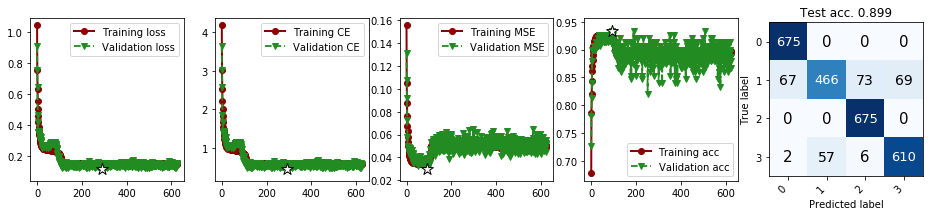

<Figure size 360x288 with 0 Axes>

In [9]:
if y_w is not None:
    print('Training Upperbound')
    numpy.random.seed(random_state)
    model = make_model(log_loss)

    X_aux_train = numpy.concatenate((X_w, X_wt_train))
    Y_aux_train = numpy.concatenate((Y_w, Y_wt_train))
    
    print('Training set intial performance')
    print_performance(model, X_aux_train, Y_aux_train)
    print('Validation set intial performance')
    print_performance(model, X_wt_val, Y_wt_val)
    history = model.fit(X_aux_train, Y_aux_train, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)

    plot_results(model, X_wt_test, y_wt_test, history)

    print('A Keras Logistic Regression trained with all the real labels ({} samples)'.format(Y_aux_train.shape[0]))
    acc_upperbound = (model.predict_proba(X_wt_test).argmax(axis=1) == y_wt_test).mean()
    print('Accuracy = {}'.format(acc_upperbound))
else:
    acc_upperbound = None

## 2.b.2. Lowerbound with a small amount of true labels

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Training Lowerbound
Sample of train labels = [[0 0 0 1]
 [0 0 0 1]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01200: early stopping
A Keras Logistic Regression trained with only training true labels (149 samples)
Accuracy = 0.7614814814814815


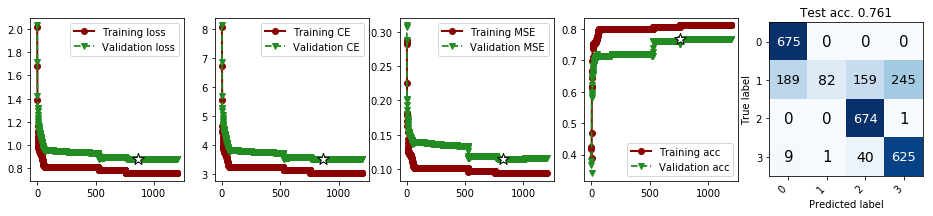

<Figure size 360x288 with 0 Axes>

In [10]:
numpy.random.seed(random_state)
model = make_model(log_loss)

print('Training Lowerbound')
print('Sample of train labels = {}'.format(numpy.round(Y_wt_train[:2], decimals=2)))
print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
history = model.fit(X_wt_train, Y_wt_train, 
                    validation_data=(X_wt_val, Y_wt_val),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size, shuffle=True)

plot_results(model, X_wt_test, y_wt_test, history)

print('A Keras Logistic Regression trained with only training true labels ({} samples)'.format(Y_wt_train.shape[0]))
acc_lowerbound = (model.predict_proba(X_wt_test).argmax(axis=1) == y_wt_test).mean()
print('Accuracy = {}'.format(acc_lowerbound))

## 2.b.3. Training directly with different proportions of weak labels

In [11]:
list_weak_proportions = numpy.array([0.0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0])
list_weak_proportions = numpy.array([0.0, 0.1, 0.3, 0.5, 0.8, 1.0])
list_weak_proportions = numpy.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
acc = {}

## 2.b.4. Training with different proportions of true labels if available

Training Upperbound with increasing number of true labels
Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 00418: early stopping
Number of weak samples = 70 from total 219, Accuracy = 0.764
Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 00531: early stopping
Number of weak samples = 140 from total 289, Accuracy = 0.772
Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 00471: early stopping
Number of weak samples = 210 from total 359, Accuracy = 0.796
Sample of first weights = [-0.087 -0.

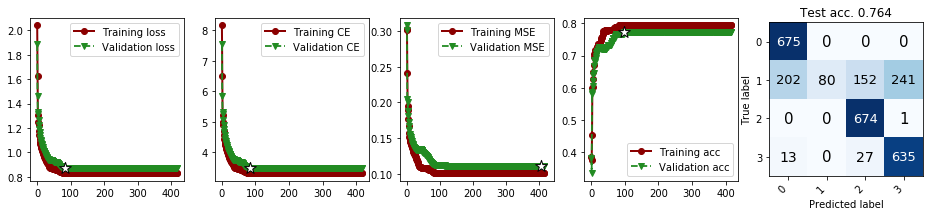

<Figure size 360x288 with 0 Axes>

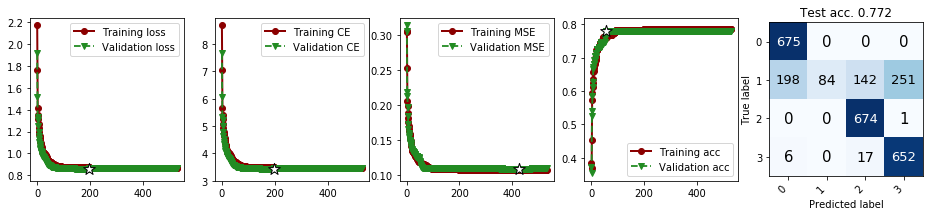

<Figure size 360x288 with 0 Axes>

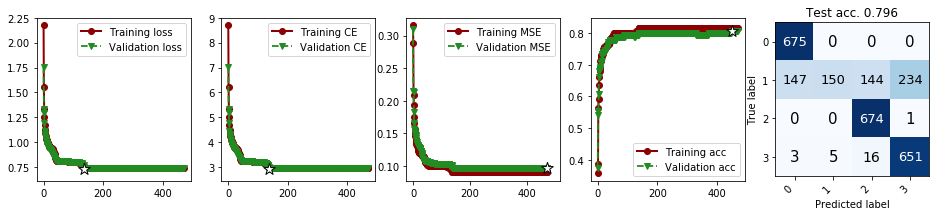

<Figure size 360x288 with 0 Axes>

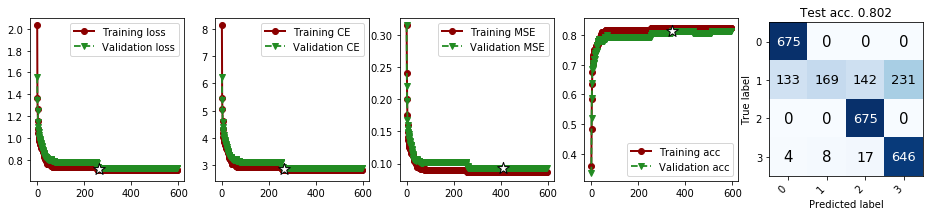

<Figure size 360x288 with 0 Axes>

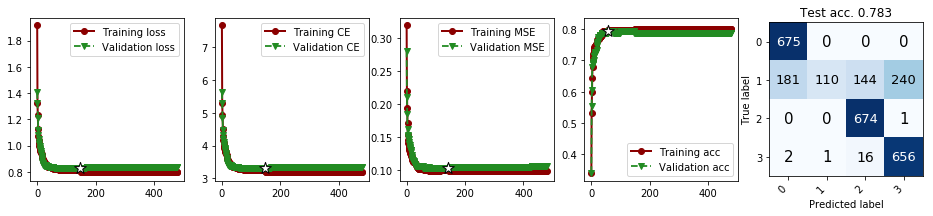

<Figure size 360x288 with 0 Axes>

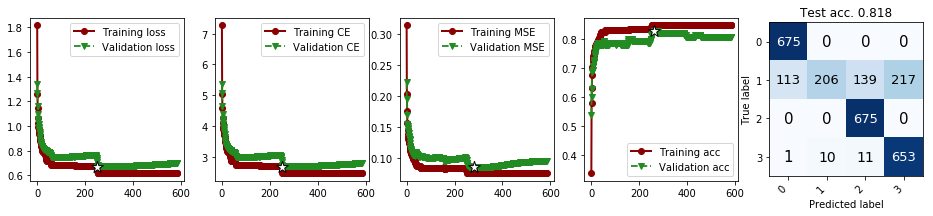

<Figure size 360x288 with 0 Axes>

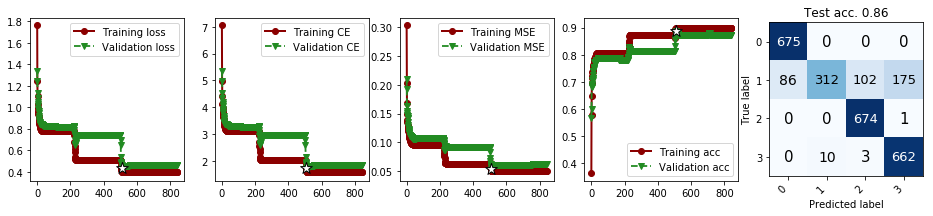

<Figure size 360x288 with 0 Axes>

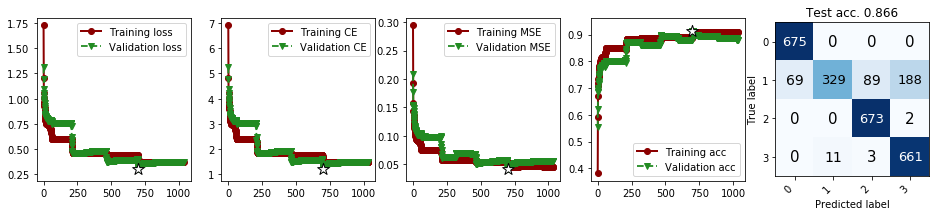

<Figure size 360x288 with 0 Axes>

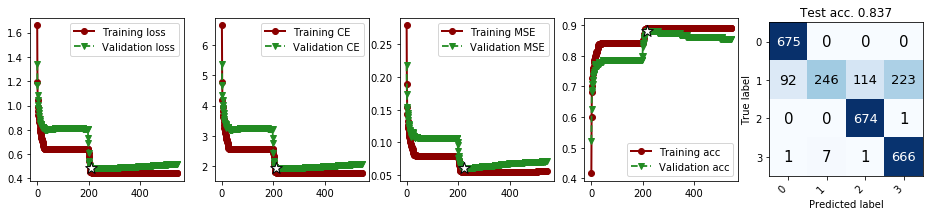

<Figure size 360x288 with 0 Axes>

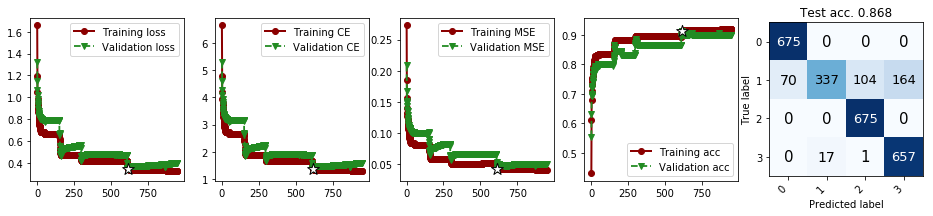

<Figure size 360x288 with 0 Axes>

In [12]:
if y_w is not None:
    print('Training Upperbound with increasing number of true labels')
    method = 'True'
    acc[method] = numpy.zeros_like(list_weak_proportions)
    for i, weak_proportion in enumerate(list_weak_proportions):
        last_index = int(weak_proportion*X_w.shape[0])


        X_aux_train = numpy.concatenate((X_w[:last_index], X_wt_train))
        Y_aux_train = numpy.concatenate((Y_w[:last_index], Y_wt_train))

        numpy.random.seed(random_state)
        model = make_model(log_loss)

        print('Sample of train labels = {}'.format(numpy.round(Y_aux_train[:2], decimals=2)))
        print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
        history = model.fit(X_aux_train, Y_aux_train,
                            validation_data=(X_wt_val, Y_wt_val),
                            epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                            batch_size=batch_size, shuffle=True)
        # 5. Evaluate the model in the test set with true labels
        y_pred = model.predict(X_wt_test).argmax(axis=1)
        acc[method][i] = (y_pred == y_wt_test).mean()
        print('Number of weak samples = {} from total {}, Accuracy = {:.3f}'.format(last_index, Y_aux_train.shape[0], acc[method][i]))

        plot_results(model, X_wt_test, y_wt_test, history)

Training Weak
Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01292: early stopping
Number of weak samples = 70 from total 219, Accuracy = 0.781
Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01625: early stopping
Number of weak samples = 140 from total 289, Accuracy = 0.794
Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01191: early stopping
Number of weak samples = 210 from total 359, Accuracy = 0.794
Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = 

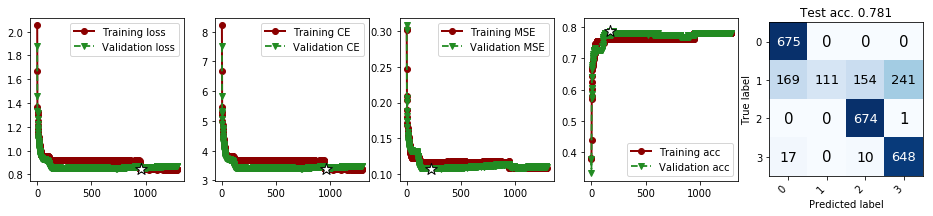

<Figure size 360x288 with 0 Axes>

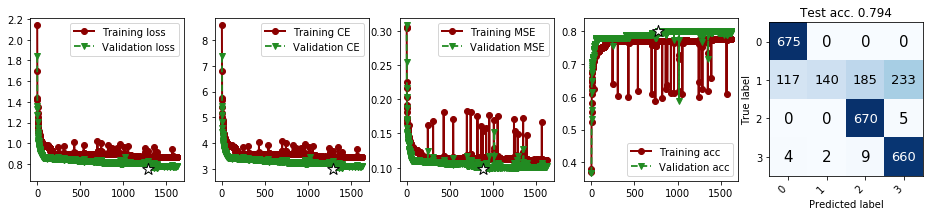

<Figure size 360x288 with 0 Axes>

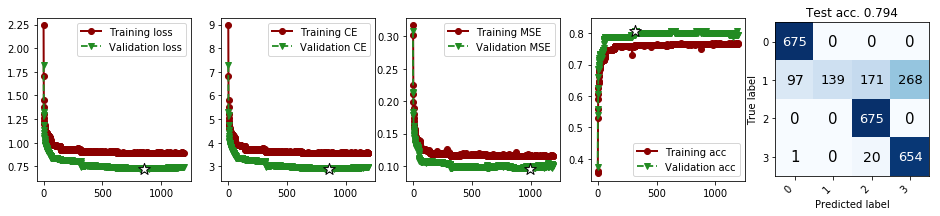

<Figure size 360x288 with 0 Axes>

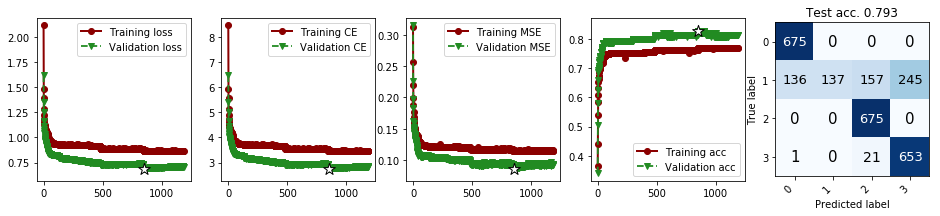

<Figure size 360x288 with 0 Axes>

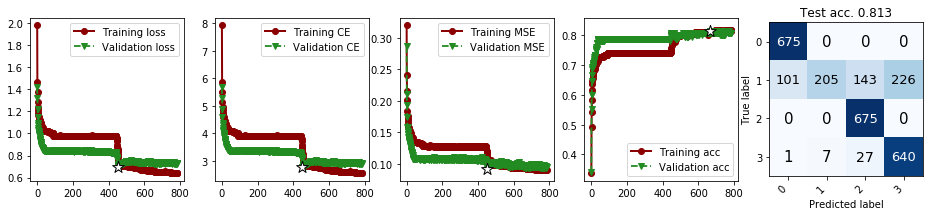

<Figure size 360x288 with 0 Axes>

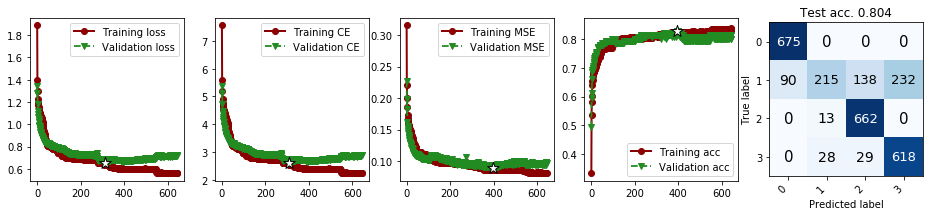

<Figure size 360x288 with 0 Axes>

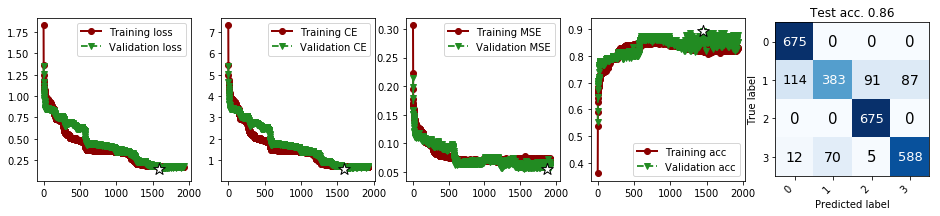

<Figure size 360x288 with 0 Axes>

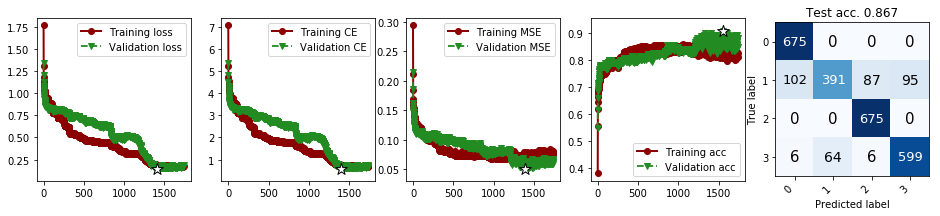

<Figure size 360x288 with 0 Axes>

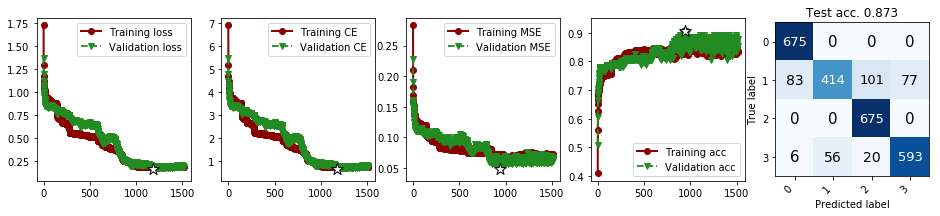

<Figure size 360x288 with 0 Axes>

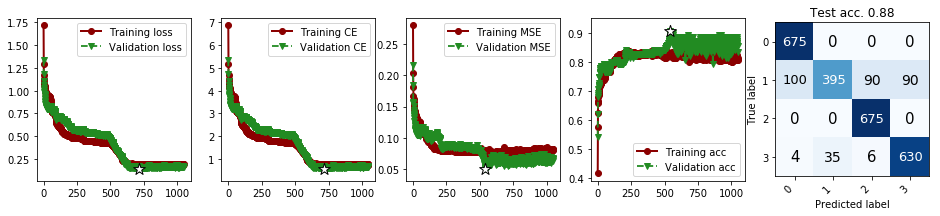

<Figure size 360x288 with 0 Axes>

In [13]:
method = 'Weak'
print('Training {}'.format(method))
acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_w.shape[0])
    
    
    X_aux_train = numpy.concatenate((X_w[:last_index], X_wt_train))
    Z_aux_train = numpy.concatenate((Z_w[:last_index], Y_wt_train))
    
    numpy.random.seed(random_state)
    model = make_model(log_loss)

    print('Sample of train labels = {}'.format(numpy.round(Z_aux_train[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    history = model.fit(X_aux_train, Z_aux_train,
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} from total {}, Accuracy = {:.3f}'.format(last_index, Z_aux_train.shape[0], acc[method][i]))
    
    plot_results(model, X_wt_test, y_wt_test, history)

# 3. Train EM

## 3.a. Learning mixing matrix M

../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = alpha
/home/maikel/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Weak count
[[ 0  0  0  0]
 [ 5  3  3 35]
 [ 2  4 33  1]
 [ 0  0  0  0]
 [ 1 33  2  3]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [33  1  3  3]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]
q0 = 0.9791579241852008, q1 = 0.02084207581479927
M_0 shape = (16, 4)
[[0.    0.    0.    0.   ]
 [0.122 0.073 0.073 0.833]
 [0.049 0.098 0.805 0.024]
 [0.    0.    0.    0.   ]
 [0.024 0.805 0.049 0.071]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.805 0.024 0.073 0.071]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]
M_1 shape = (4, 4)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
M_EM shape = (20, 4)
[[0.    0.    0.    0.   ]
 [0.119 0.072 0.072 0.816]
 [0.048 0.096 0.788 0.023]
 [0.    0.    0.    0.   ]
 [0.024 0.788 0.048 0.07 ]
 [0.    0

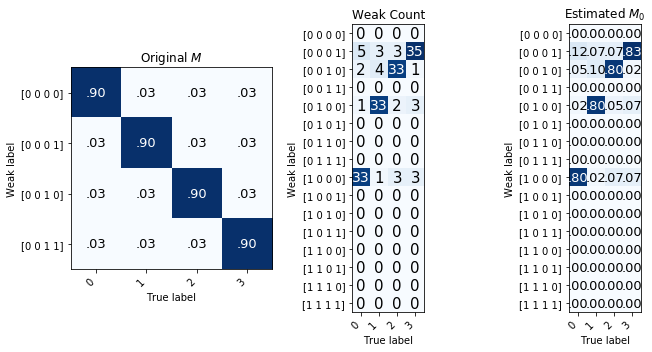

In [14]:
categories = range(n_classes)
from wlc.WLweakener import newWeakCount
w_count = newWeakCount(Z_wt_train, Y_wt_train, range(n_classes), reg='Partial', Z_reg=Z_w, alpha=1).astype(int)
print("Weak count\n{}".format(w_count.todense()))
# 1.a. Learn a mixing matrix using training with weak and true labels
M_0 = estimate_M(Z_wt_train, Y_wt_train, range(n_classes), reg='Partial', Z_reg=Z_w, alpha=1)
M_1 = computeM(c=n_classes, method='supervised')
q_0 = X_w.shape[0] / float(X_w.shape[0] + X_wt_train.shape[0])
q_1 = X_wt_train.shape[0] / float(X_w.shape[0] + X_wt_train.shape[0])
M_EM = numpy.array(numpy.concatenate((q_0*M_0, q_1*M_1), axis=0))

print('q0 = {}, q1 = {}'.format(q_0, q_1))
print("M_0 shape = {}\n{}".format(M_0.shape, numpy.round(M_0, decimals=3)))
print("M_1 shape = {}\n{}".format(M_1.shape, numpy.round(M_1, decimals=3)))
print("M_EM shape = {}\n{}".format(M_EM.shape, numpy.round(M_EM, decimals=3)))
print("Z_wt\n{}".format(numpy.round(Z_wt_train[:5])))
print("Y_wt\n{}".format(numpy.round(Y_wt_train[:5])))

if M is not None:
    # 1.b. True mixing matrix
    M_T = numpy.concatenate((q_0*M, q_1*M_1), axis=0)
    print("M_T shape = {}\n{}".format(M_T.shape, numpy.round(M_T, decimals=3)))
    
    if M_T.shape == M_EM.shape:
        print('Mean Squared Difference between True and estimated M = {}'.format(numpy.mean(numpy.square(M_T - M_EM))))

    # FIXME problem here when true M is square and estimated is not
    m_list = [(r'Original $M$', M), (r'Weak Count', w_count.todense()),
              (r'Estimated $M_0$', M_0)]
    if M.shape == M_0.shape:
        m_list.append((r'$|M - M_0|$', numpy.abs(M - M_0)))
        
    fig = plt.figure(figsize=(10, 5))
    for i, (title, m_aux) in enumerate(m_list):
        ax = fig.add_subplot(1,len(m_list),i+1)
        ax.set_title(title)
        if n_classes < 5:
            from wlc.WLweakener import binarizeWeakLabels
            rows = binarizeWeakLabels(numpy.arange(m_aux.shape[0]), c=m_aux.shape[1])
            fig = plot_heatmap(m_aux, rows=rows, title=title, fig=fig, ax=ax,
                               xlabel='True label', ylabel='Weak label')
        else:
            ax.imshow(m_aux, interpolation='nearest', aspect='auto')

## 3.b. Train with true mixing matrix M if available

In [15]:
m = {}

def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    Q = y_true * y_pred
    Z_em_train = Q / K.sum(Q, axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

### Index are different

- Be careful as the indices from the true matrix can be smaller than the estimated, as the estimated is always the long version while the original one can be square

Z_w_index [3 1 3 3 2]
Y_wt_train_index [3 3 2 2 3]
Training EM M original
Mixing matrix M shape = (8, 4)
[[0.88124213 0.0326386  0.0326386  0.0326386 ]
 [0.0326386  0.88124213 0.0326386  0.0326386 ]
 [0.0326386  0.0326386  0.88124213 0.0326386 ]
 [0.0326386  0.0326386  0.0326386  0.88124213]
 [0.02084208 0.         0.         0.        ]
 [0.         0.02084208 0.         0.        ]
 [0.         0.         0.02084208 0.        ]
 [0.         0.         0.         0.02084208]]
Training objective scores


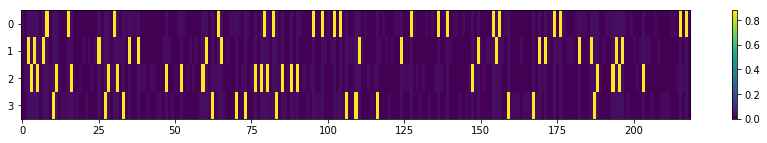

Count of indices in training
[(0, 19), (1, 18), (2, 20), (3, 13), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


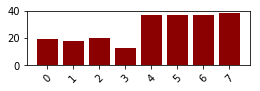

All training indices for the weak labels


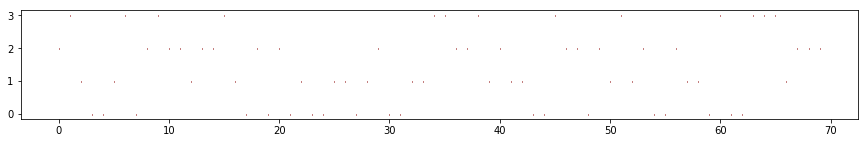

All training indices for the full set


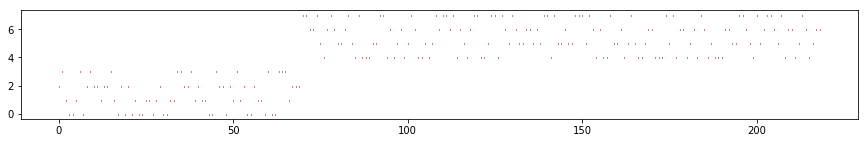

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.02 0.   0.   0.  ]
 [0.   0.   0.02 0.  ]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.8236942199698032
CE = 2.0256318544179304
MSE = 0.23564273632963614
Acc. = 0.4337899543378995
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00664: early stopping
Number of weak samples = 70 and true = 149, Accuracy = 0.773
Training objective scores


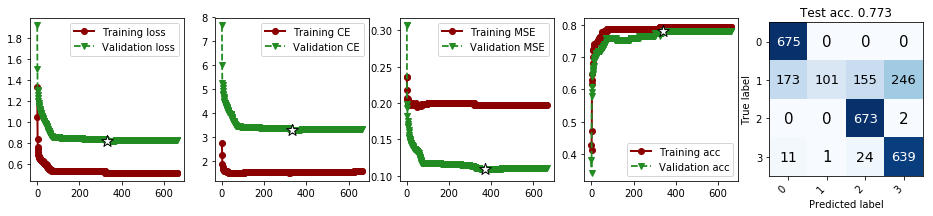

<Figure size 360x288 with 0 Axes>

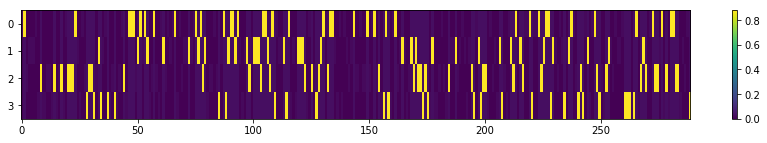

Count of indices in training
[(0, 39), (1, 34), (2, 39), (3, 28), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


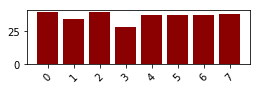

All training indices for the weak labels


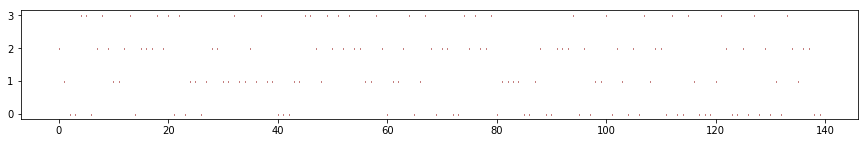

All training indices for the full set


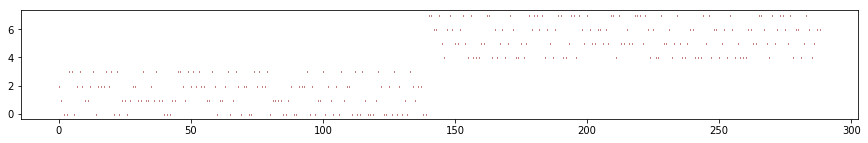

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.02 0.   0.   0.  ]
 [0.88 0.03 0.03 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.5185030944819635
CE = 1.6764517007619029
MSE = 0.24796296131218185
Acc. = 0.4083044982698962
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00885: early stopping
Number of weak samples = 140 and true = 149, Accuracy = 0.786
Training objective scores


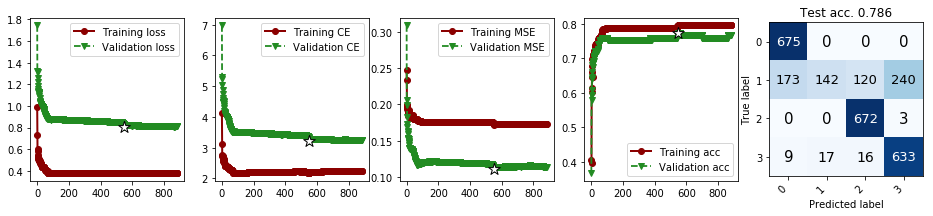

<Figure size 360x288 with 0 Axes>

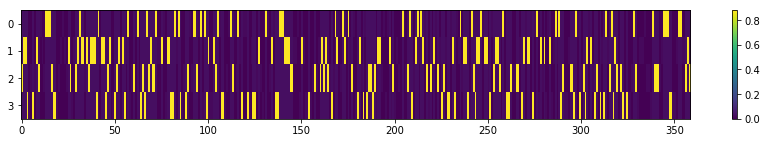

Count of indices in training
[(0, 46), (1, 58), (2, 53), (3, 53), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


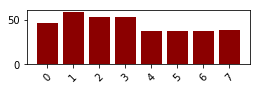

All training indices for the weak labels


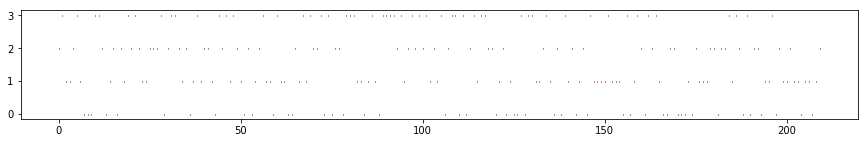

All training indices for the full set


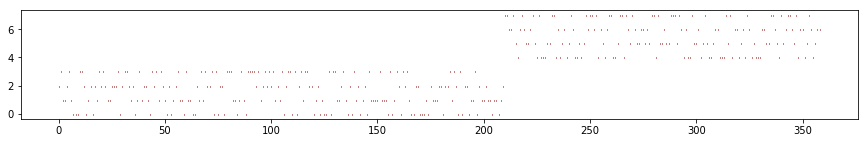

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.03 0.03 0.88 0.03]
 [0.03 0.88 0.03 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.3409183173871466
CE = 1.471263051487161
MSE = 0.2575531085207912
Acc. = 0.38440111420612816
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00572: early stopping
Number of weak samples = 210 and true = 149, Accuracy = 0.774
Training objective scores


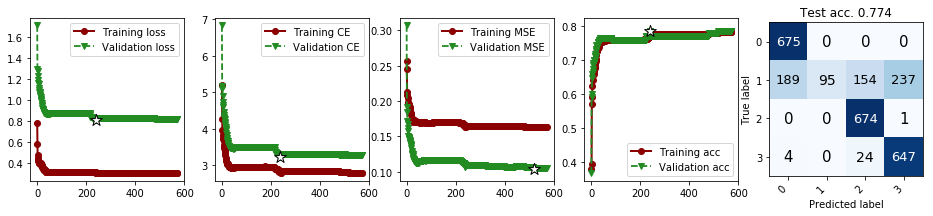

<Figure size 360x288 with 0 Axes>

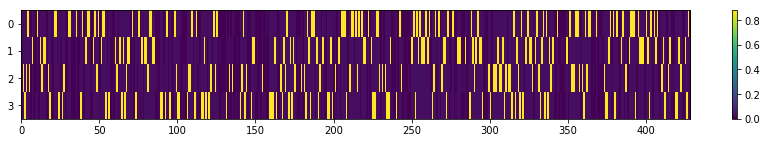

Count of indices in training
[(0, 79), (1, 72), (2, 60), (3, 69), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


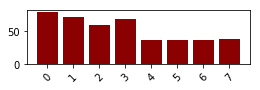

All training indices for the weak labels


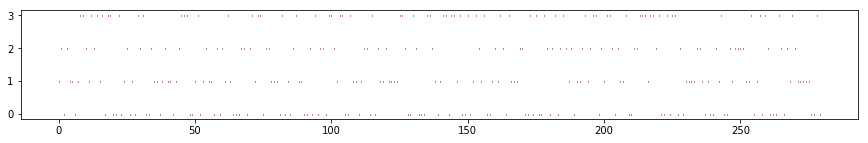

All training indices for the full set


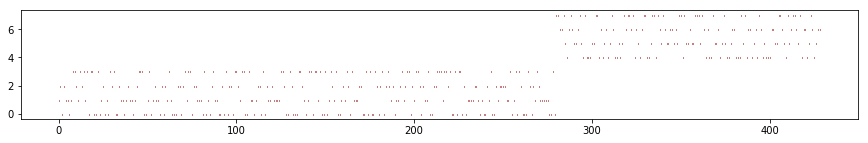

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.02 0.   0.   0.  ]
 [0.03 0.03 0.88 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.233903654500436
CE = 1.3517927647338244
MSE = 0.27512457720522815
Acc. = 0.34498834498834496
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00374: early stopping
Number of weak samples = 280 and true = 149, Accuracy = 0.770
Training objective scores


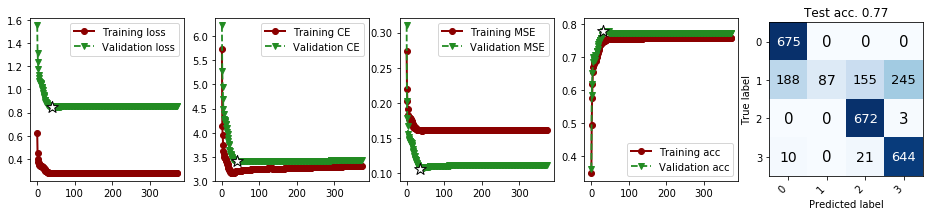

<Figure size 360x288 with 0 Axes>

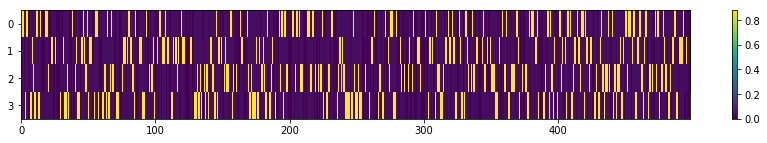

Count of indices in training
[(0, 84), (1, 78), (2, 93), (3, 95), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


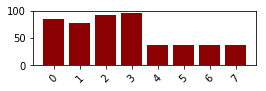

All training indices for the weak labels


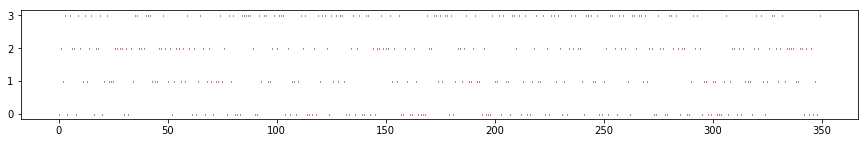

All training indices for the full set


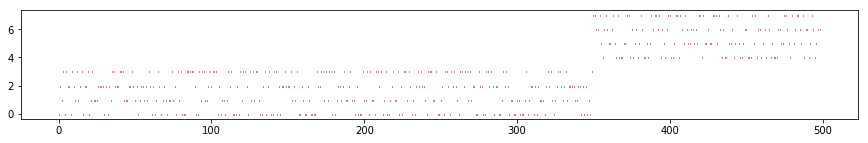

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.88 0.03 0.03 0.03]
 [0.88 0.03 0.03 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.0987854417488887
CE = 1.2043523210056026
MSE = 0.25476517372498186
Acc. = 0.3907815631262525
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01631: early stopping
Number of weak samples = 350 and true = 149, Accuracy = 0.540
Training objective scores


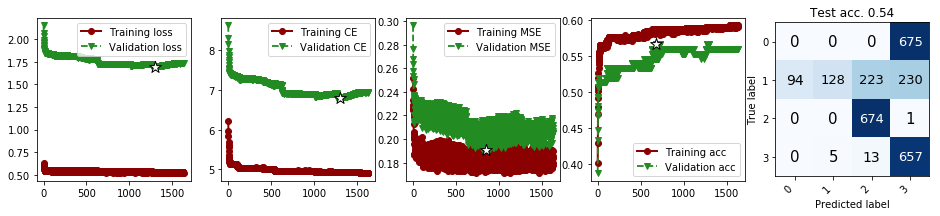

<Figure size 360x288 with 0 Axes>

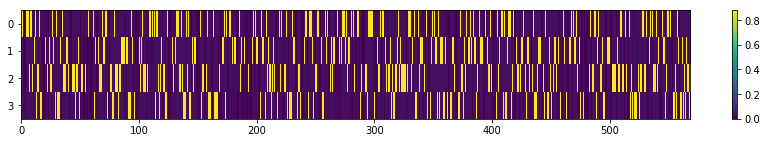

Count of indices in training
[(0, 111), (1, 99), (2, 118), (3, 92), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


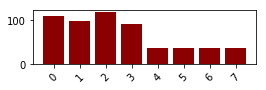

All training indices for the weak labels


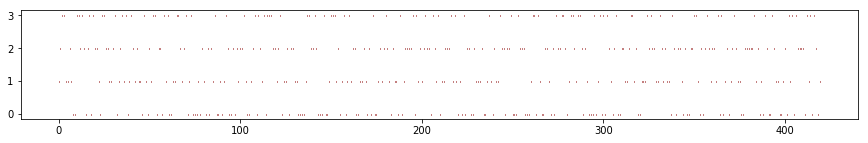

All training indices for the full set


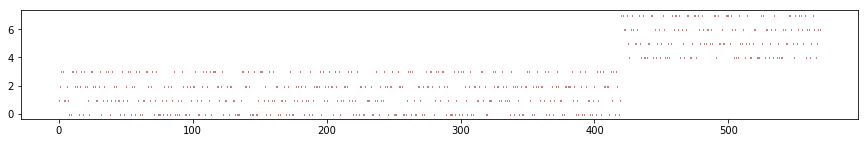

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.88 0.03 0.03 0.03]
 [0.88 0.03 0.03 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.0288238368468838
CE = 1.1201957275504761
MSE = 0.25459365060033146
Acc. = 0.3936731107205624
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00974: early stopping
Number of weak samples = 420 and true = 149, Accuracy = 0.793
Training objective scores


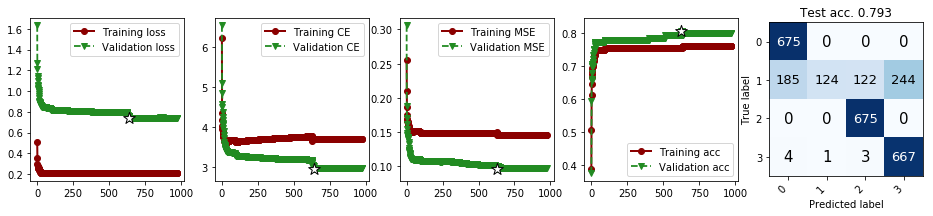

<Figure size 360x288 with 0 Axes>

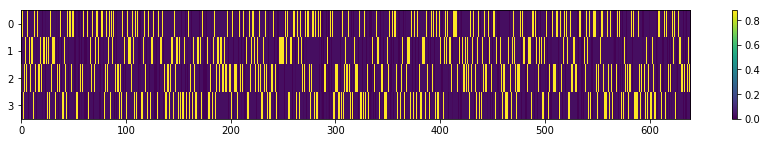

Count of indices in training
[(0, 125), (1, 108), (2, 131), (3, 126), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


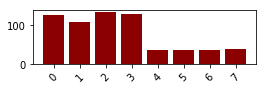

All training indices for the weak labels


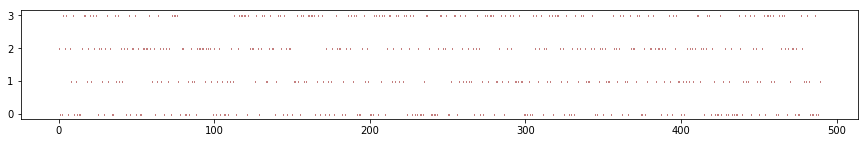

All training indices for the full set


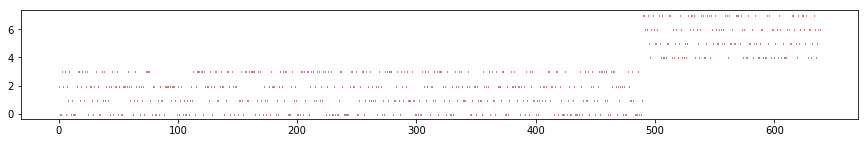

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.03 0.03 0.88 0.03]
 [0.88 0.03 0.03 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.9779142084461071
CE = 1.0667126786893373
MSE = 0.2604654667660626
Acc. = 0.37715179968701096
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01212: early stopping
Number of weak samples = 490 and true = 149, Accuracy = 0.545
Training objective scores


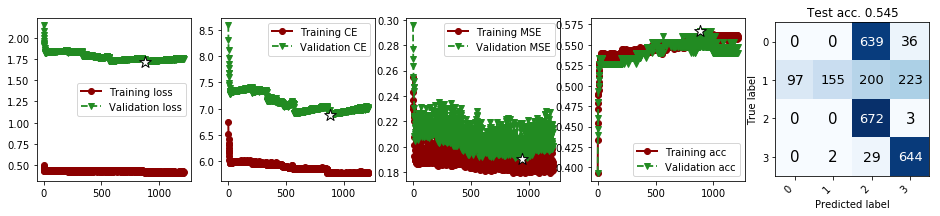

<Figure size 360x288 with 0 Axes>

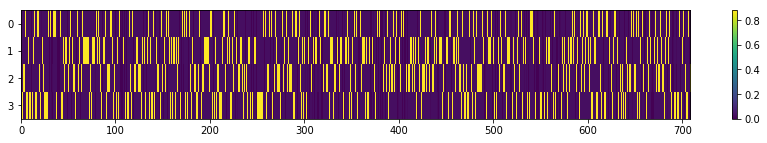

Count of indices in training
[(0, 117), (1, 159), (2, 142), (3, 142), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


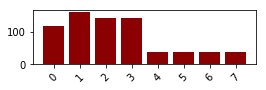

All training indices for the weak labels


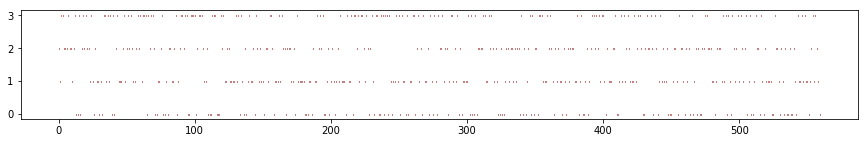

All training indices for the full set


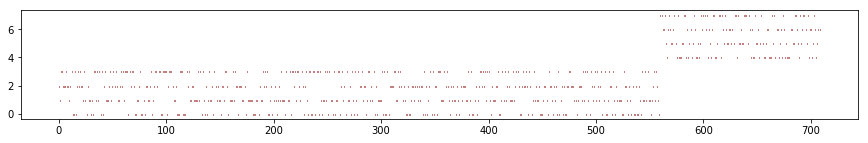

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.   0.   0.02 0.  ]
 [0.03 0.03 0.03 0.88]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.9424345033282342
CE = 1.0198425988045534
MSE = 0.2634373816951009
Acc. = 0.37376586741889983
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01658: early stopping
Number of weak samples = 560 and true = 149, Accuracy = 0.843
Training objective scores


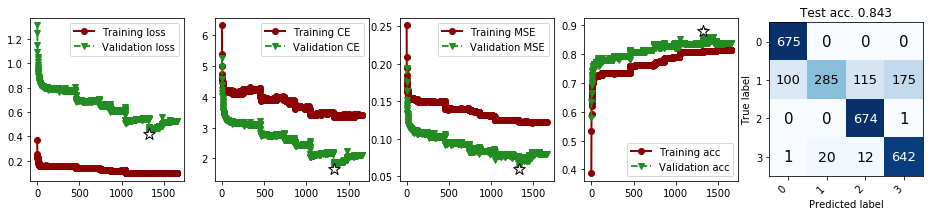

<Figure size 360x288 with 0 Axes>

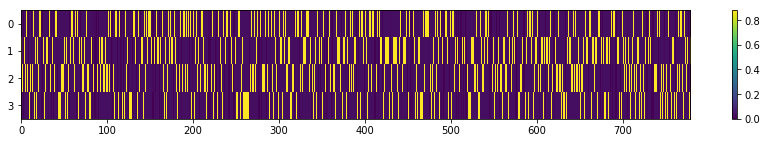

Count of indices in training
[(0, 162), (1, 170), (2, 166), (3, 132), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


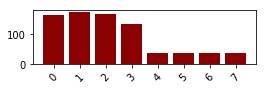

All training indices for the weak labels


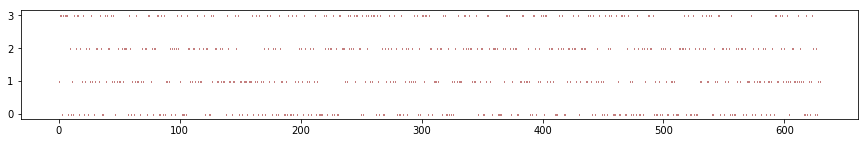

All training indices for the full set


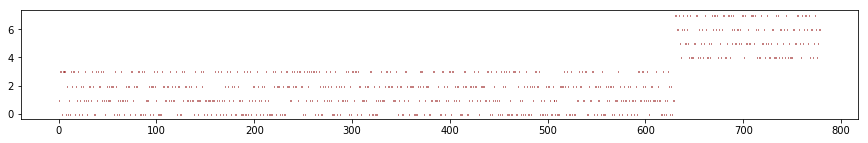

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.03 0.88 0.03 0.03]
 [0.03 0.03 0.88 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.9171390807318218
CE = 0.9937847600401825
MSE = 0.27106095035585626
Acc. = 0.3504492939666239
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01337: early stopping
Number of weak samples = 630 and true = 149, Accuracy = 0.576
Training objective scores


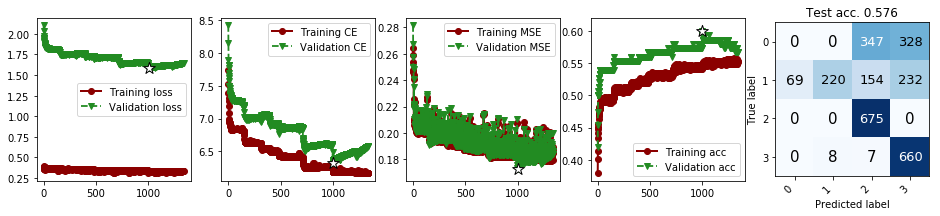

<Figure size 360x288 with 0 Axes>

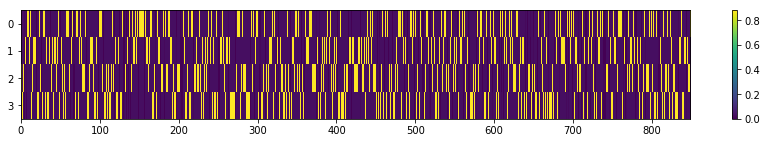

Count of indices in training
[(0, 177), (1, 171), (2, 168), (3, 184), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.12195122 0.07317073 0.07317073 0.83333333]
 [0.04878049 0.09756098 0.80487805 0.02380952]
 [0.         0.         0.         0.        ]
 [0.02439024 0.80487805 0.04878049 0.07142857]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[[0.19512195 0.97560976 0.92682927 0.92857143]]


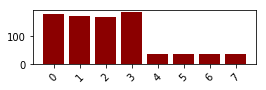

All training indices for the weak labels


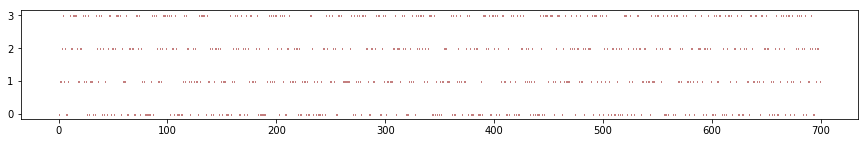

All training indices for the full set


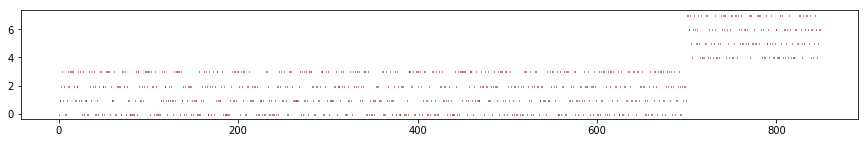

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.03 0.03 0.88 0.03]
 [0.03 0.03 0.03 0.88]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.8758069051294204
CE = 0.9414715752641504
MSE = 0.2639773205243282
Acc. = 0.37338044758539457
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01249: early stopping
Number of weak samples = 700 and true = 149, Accuracy = 0.594


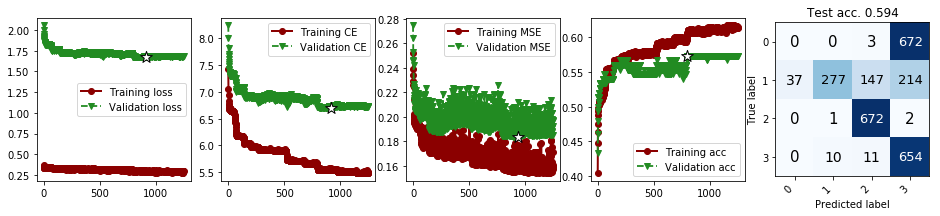

<Figure size 360x288 with 0 Axes>

In [16]:
Z_w_index = weak_to_index(Z_w, method=M_method)
Y_wt_train_index = weak_to_index(Y_wt_train, method='supervised')

print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_train_index {}'.format(Y_wt_train_index[:5]))

method = 'EM M original'
print('Training {}'.format(method))
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_T
print('Mixing matrix M shape = {}'.format(m[method].shape))
print(m[method])
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_w.shape[0])
    training_choice = numpy.random.choice(Z_w.shape[0], last_index)
    
    ZY_wt_aux_index = numpy.concatenate((Z_w_index[training_choice], Y_wt_train_index + M.shape[0]))
    X_wt_aux = numpy.concatenate((X_w[training_choice], X_wt_train), axis=0)
    ZY_wt_aux = m[method][ZY_wt_aux_index]

    X_wt_aux, ZY_wt_aux = shuffle(X_wt_aux, ZY_wt_aux)
    
    print('Training objective scores')
    fig = plt.figure(figsize=(15, 2))
    plt.imshow(ZY_wt_aux.T, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.show()

    from collections import Counter
    c = Counter(ZY_wt_aux_index)
    c = sorted(c.items())
    print('Count of indices in training')
    print(c)
    print('Corresponding mixing matrix rows')
    print(m_aux[[x[0] for x in c]])
    print('Columns marginal')
    print(m_aux[[x[0] for x in c]].sum(axis=0))
    fig = plt.figure(figsize=(4, 1))
    ax = fig.add_subplot(111)
    _ = ax.bar(range(len(c)), [x[1] for x in c])
    _ = ax.set_xticks(range(len(c)))
    _ = ax.set_xticklabels([x[0] for x in c], rotation=45)
    plt.show()

    print('All training indices for the weak labels')
    fig = plt.figure(figsize=(15, 2))
    plt.scatter(range(last_index), Z_w_index[training_choice], marker='|', s=1)
    plt.show()
    
    print('All training indices for the full set')
    fig = plt.figure(figsize=(15, 2))
    plt.scatter(range(len(ZY_wt_aux_index)), ZY_wt_aux_index, marker='|', s=1)
    plt.show()
    
    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    print('Sample of train labels = {}'.format(numpy.round(ZY_wt_aux[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    print('Training set intial performance')
    print_performance(model, X_wt_aux, ZY_wt_aux)
    print('Validation set intial performance')
    print_performance(model, X_wt_val, Y_wt_val)
    history = model.fit(X_wt_aux, ZY_wt_aux, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} and true = {}, Accuracy = {:.3f}'.format(last_index, X_wt_train.shape[0], acc[method][i]))
    
    plot_results(model, X_wt_test, y_wt_test, history)

## 3.c. Train with estimated mixing matrix M_ME

Z_w_index [1 4 1 1 2]
Y_wt_train_index [3 3 2 2 3]
Training EM M estimated
Mixing matrix M shape = (20, 4)
[[0.         0.         0.         0.        ]
 [0.1194095  0.0716457  0.0716457  0.81596494]
 [0.0477638  0.0955276  0.78810272 0.02331328]
 [0.         0.         0.         0.        ]
 [0.0238819  0.78810272 0.0477638  0.06993985]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.78810272 0.0238819  0.0716457  0.06993985]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.02084208 0.         0.         0.        ]
 [0.         0.02084208 0.         0.        ]
 [0.         0.         0.02084208 0.        ]


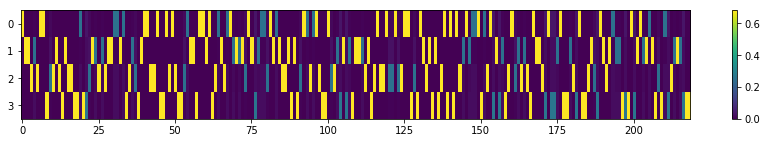

Count of indices in training
[(1, 15), (2, 15), (4, 22), (8, 18), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.03897984 0.02338791 0.02338791 0.26636225]
 [0.01559194 0.03118387 0.25726696 0.00761035]
 [0.00779597 0.25726696 0.01559194 0.02283105]
 [0.25726696 0.00779597 0.02338791 0.02283105]
 [0.6803653  0.         0.         0.        ]
 [0.         0.6803653  0.         0.        ]
 [0.         0.         0.6803653  0.        ]
 [0.         0.         0.         0.6803653 ]]
Columns marginal
[1. 1. 1. 1.]


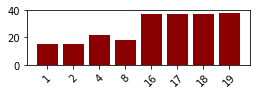

All training indices for the weak labels


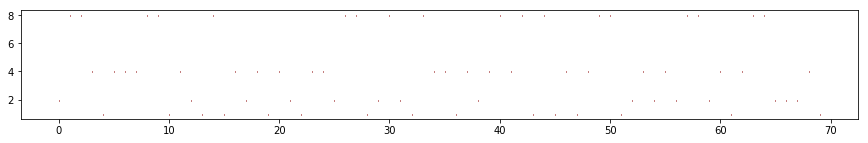

All training indices for the full set


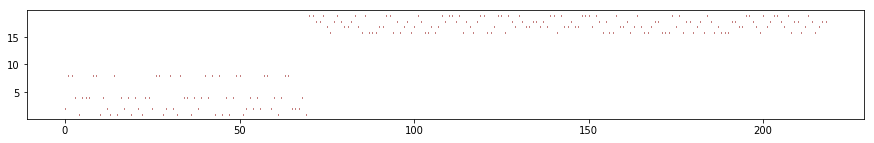

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.68 0.   0.   0.  ]
 [0.   0.68 0.   0.  ]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.4001122654691212
CE = 1.880937569794349
MSE = 0.21736558232440337
Acc. = 0.3744292237442922
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00425: early stopping
Number of weak samples = 70 and true = 149, Accuracy = 0.757


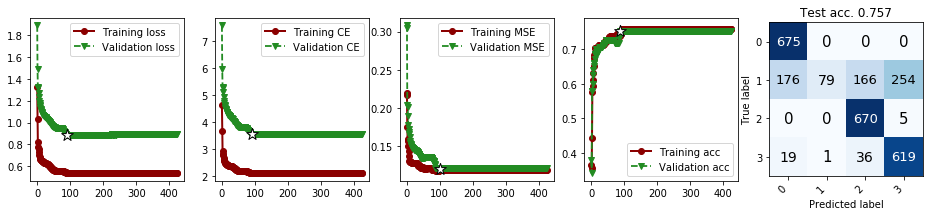

<Figure size 360x288 with 0 Axes>

Size set weak = 140, size set true = 149
q_0 = 0.4844290657439446, q_1 = 0.5155709342560554
[[0.         0.         0.         0.        ]
 [0.05907672 0.03544603 0.03544603 0.40369089]
 [0.02363069 0.04726137 0.38990632 0.01153403]
 [0.         0.         0.         0.        ]
 [0.01181534 0.38990632 0.02363069 0.03460208]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.38990632 0.01181534 0.03544603 0.03460208]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.51557093 0.         0.         0.        ]
 [0.         0.51557093 0.         0.        ]
 [0.         0.         0.51557093 0.        ]
 [0.         0.

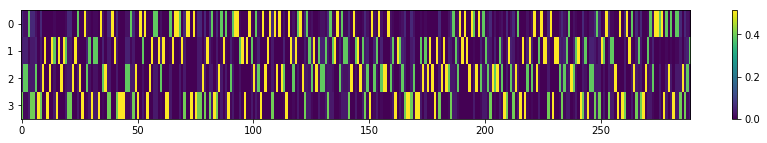

Count of indices in training
[(1, 39), (2, 38), (4, 34), (8, 29), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.05907672 0.03544603 0.03544603 0.40369089]
 [0.02363069 0.04726137 0.38990632 0.01153403]
 [0.01181534 0.38990632 0.02363069 0.03460208]
 [0.38990632 0.01181534 0.03544603 0.03460208]
 [0.51557093 0.         0.         0.        ]
 [0.         0.51557093 0.         0.        ]
 [0.         0.         0.51557093 0.        ]
 [0.         0.         0.         0.51557093]]
Columns marginal
[1. 1. 1. 1.]


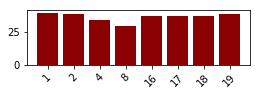

All training indices for the weak labels


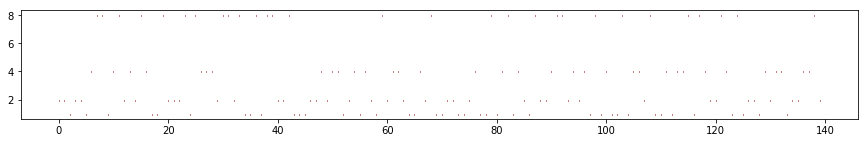

All training indices for the full set


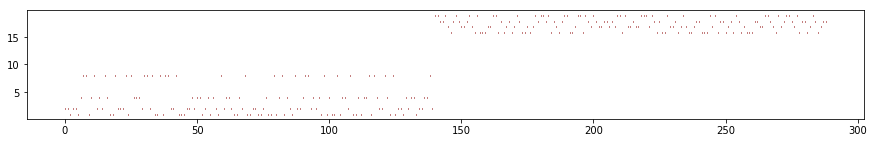

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.06 0.04 0.04 0.4 ]
 [0.02 0.05 0.39 0.01]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.2051934311468322
CE = 1.5380059334114264
MSE = 0.19648743397895516
Acc. = 0.42214532871972316
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00438: early stopping
Number of weak samples = 140 and true = 149, Accuracy = 0.760


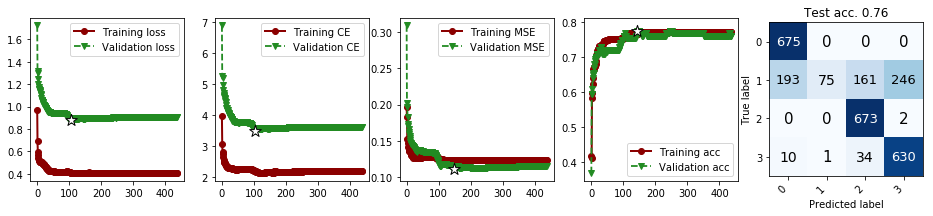

<Figure size 360x288 with 0 Axes>

Size set weak = 210, size set true = 149
q_0 = 0.584958217270195, q_1 = 0.415041782729805
[[0.         0.         0.         0.        ]
 [0.07133637 0.04280182 0.04280182 0.48746518]
 [0.02853455 0.05706909 0.47082003 0.01392758]
 [0.         0.         0.         0.        ]
 [0.01426727 0.47082003 0.02853455 0.04178273]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.47082003 0.01426727 0.04280182 0.04178273]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.41504178 0.         0.         0.        ]
 [0.         0.41504178 0.         0.        ]
 [0.         0.         0.41504178 0.        ]
 [0.         0.  

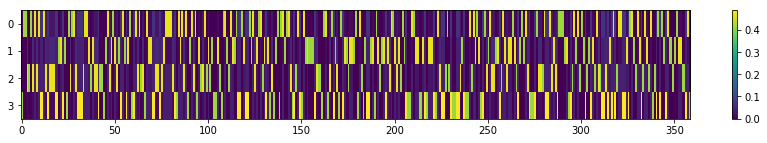

Count of indices in training
[(1, 63), (2, 44), (4, 50), (8, 53), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.07133637 0.04280182 0.04280182 0.48746518]
 [0.02853455 0.05706909 0.47082003 0.01392758]
 [0.01426727 0.47082003 0.02853455 0.04178273]
 [0.47082003 0.01426727 0.04280182 0.04178273]
 [0.41504178 0.         0.         0.        ]
 [0.         0.41504178 0.         0.        ]
 [0.         0.         0.41504178 0.        ]
 [0.         0.         0.         0.41504178]]
Columns marginal
[1. 1. 1. 1.]


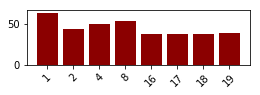

All training indices for the weak labels


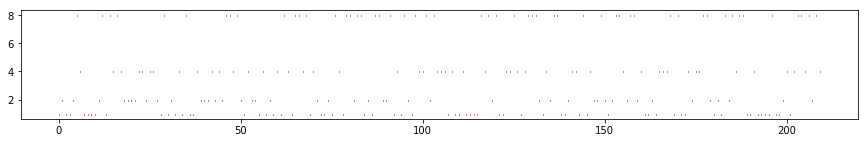

All training indices for the full set


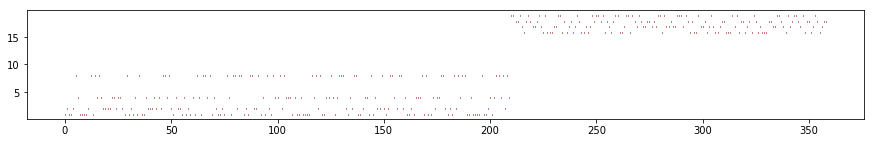

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.   0.   0.   0.42]
 [0.42 0.   0.   0.  ]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.1167277967081755
CE = 1.3721508735053964
MSE = 0.2052043034995109
Acc. = 0.362116991643454
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00419: early stopping
Number of weak samples = 210 and true = 149, Accuracy = 0.520


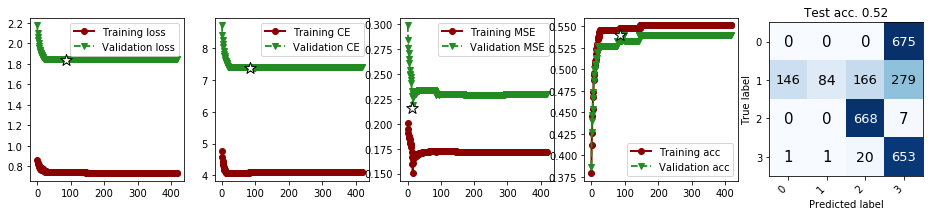

<Figure size 360x288 with 0 Axes>

Size set weak = 280, size set true = 149
q_0 = 0.6526806526806527, q_1 = 0.3473193473193473
[[0.         0.         0.         0.        ]
 [0.0795952  0.04775712 0.04775712 0.54390054]
 [0.03183808 0.06367616 0.52532833 0.01554002]
 [0.         0.         0.         0.        ]
 [0.01591904 0.52532833 0.03183808 0.04662005]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.52532833 0.01591904 0.04775712 0.04662005]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.34731935 0.         0.         0.        ]
 [0.         0.34731935 0.         0.        ]
 [0.         0.         0.34731935 0.        ]
 [0.         0.

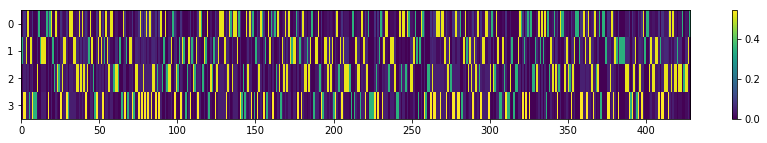

Count of indices in training
[(1, 73), (2, 76), (4, 65), (8, 66), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.0795952  0.04775712 0.04775712 0.54390054]
 [0.03183808 0.06367616 0.52532833 0.01554002]
 [0.01591904 0.52532833 0.03183808 0.04662005]
 [0.52532833 0.01591904 0.04775712 0.04662005]
 [0.34731935 0.         0.         0.        ]
 [0.         0.34731935 0.         0.        ]
 [0.         0.         0.34731935 0.        ]
 [0.         0.         0.         0.34731935]]
Columns marginal
[1. 1. 1. 1.]


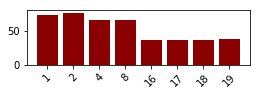

All training indices for the weak labels


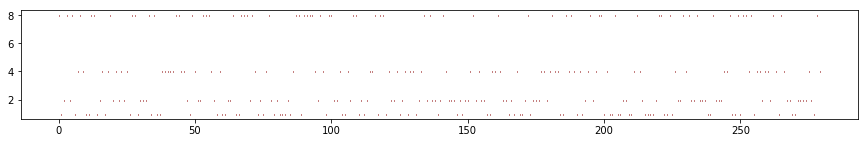

All training indices for the full set


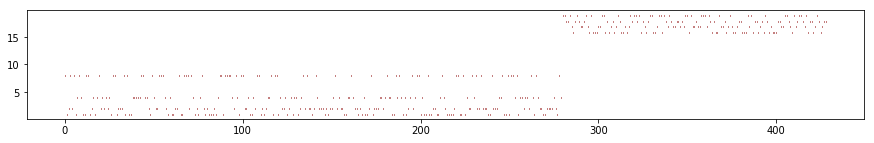

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.   0.35 0.   0.  ]
 [0.08 0.05 0.05 0.54]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.0184682956900368
CE = 1.2169075958234592
MSE = 0.20284613858514694
Acc. = 0.38927738927738925
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00572: early stopping
Number of weak samples = 280 and true = 149, Accuracy = 0.768


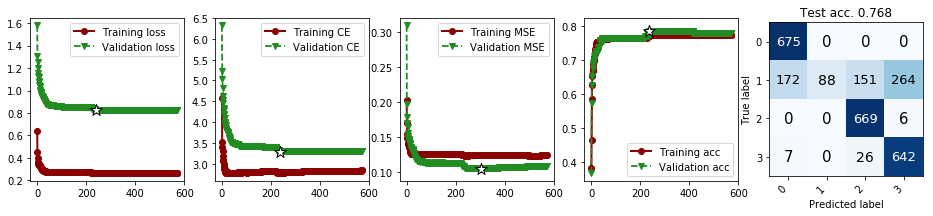

<Figure size 360x288 with 0 Axes>

Size set weak = 350, size set true = 149
q_0 = 0.7014028056112225, q_1 = 0.2985971943887776
[[0.         0.         0.         0.        ]
 [0.08553693 0.05132216 0.05132216 0.58450234]
 [0.03421477 0.06842954 0.56454372 0.01670007]
 [0.         0.         0.         0.        ]
 [0.01710739 0.56454372 0.03421477 0.0501002 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.56454372 0.01710739 0.05132216 0.0501002 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.29859719 0.         0.         0.        ]
 [0.         0.29859719 0.         0.        ]
 [0.         0.         0.29859719 0.        ]
 [0.         0.

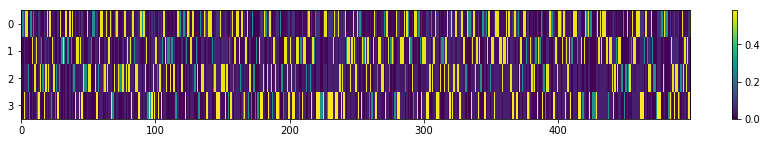

Count of indices in training
[(1, 90), (2, 82), (4, 84), (8, 94), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.08553693 0.05132216 0.05132216 0.58450234]
 [0.03421477 0.06842954 0.56454372 0.01670007]
 [0.01710739 0.56454372 0.03421477 0.0501002 ]
 [0.56454372 0.01710739 0.05132216 0.0501002 ]
 [0.29859719 0.         0.         0.        ]
 [0.         0.29859719 0.         0.        ]
 [0.         0.         0.29859719 0.        ]
 [0.         0.         0.         0.29859719]]
Columns marginal
[1. 1. 1. 1.]


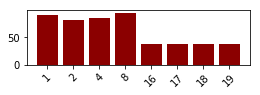

All training indices for the weak labels


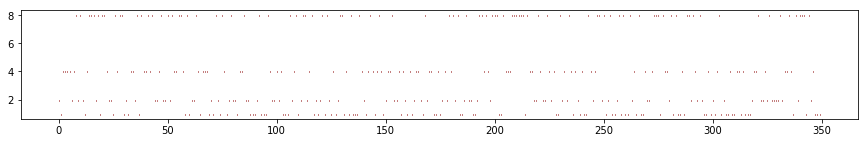

All training indices for the full set


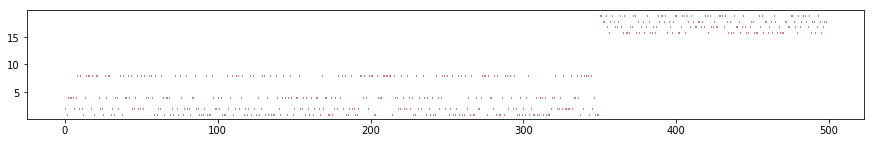

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.  0.  0.3 0. ]
 [0.3 0.  0.  0. ]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.9482438385344589
CE = 1.1133275727906369
MSE = 0.2041272282330426
Acc. = 0.3867735470941884
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00813: early stopping
Number of weak samples = 350 and true = 149, Accuracy = 0.561


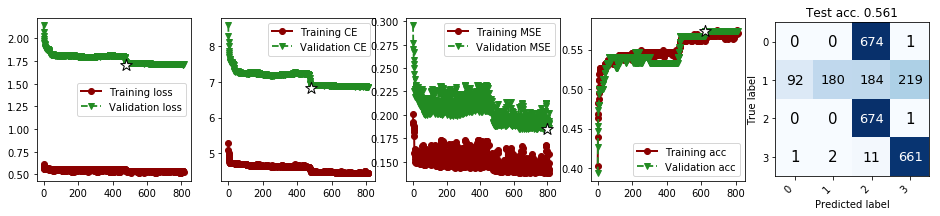

<Figure size 360x288 with 0 Axes>

Size set weak = 420, size set true = 149
q_0 = 0.7381370826010545, q_1 = 0.2618629173989455
[[0.         0.         0.         0.        ]
 [0.09001672 0.05401003 0.05401003 0.61511424]
 [0.03600669 0.07201337 0.59411033 0.01757469]
 [0.         0.         0.         0.        ]
 [0.01800334 0.59411033 0.03600669 0.05272408]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.59411033 0.01800334 0.05401003 0.05272408]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.26186292 0.         0.         0.        ]
 [0.         0.26186292 0.         0.        ]
 [0.         0.         0.26186292 0.        ]
 [0.         0.

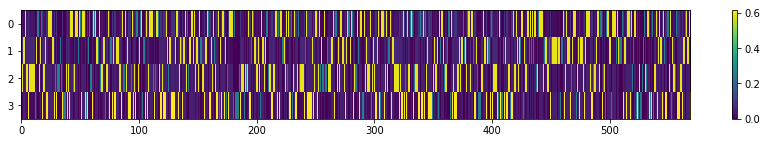

Count of indices in training
[(1, 113), (2, 107), (4, 87), (8, 113), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.09001672 0.05401003 0.05401003 0.61511424]
 [0.03600669 0.07201337 0.59411033 0.01757469]
 [0.01800334 0.59411033 0.03600669 0.05272408]
 [0.59411033 0.01800334 0.05401003 0.05272408]
 [0.26186292 0.         0.         0.        ]
 [0.         0.26186292 0.         0.        ]
 [0.         0.         0.26186292 0.        ]
 [0.         0.         0.         0.26186292]]
Columns marginal
[1. 1. 1. 1.]


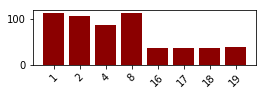

All training indices for the weak labels


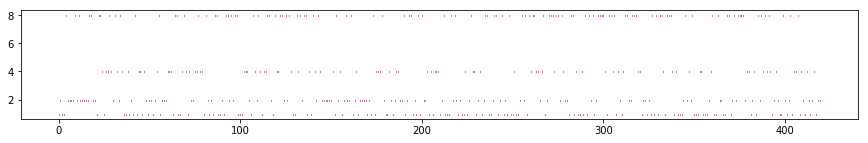

All training indices for the full set


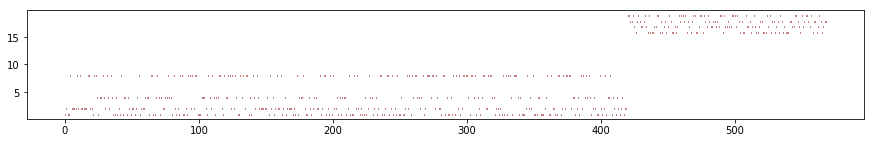

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.   0.   0.26 0.  ]
 [0.04 0.07 0.59 0.02]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.8993191937112883
CE = 1.0398085609135446
MSE = 0.20968719148518475
Acc. = 0.37258347978910367
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01002: early stopping
Number of weak samples = 420 and true = 149, Accuracy = 0.551


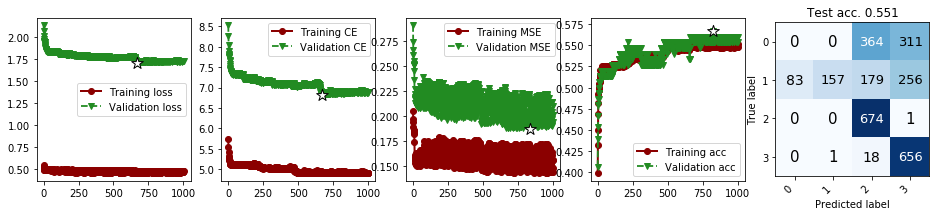

<Figure size 360x288 with 0 Axes>

Size set weak = 490, size set true = 149
q_0 = 0.7668231611893583, q_1 = 0.23317683881064163
[[0.         0.         0.         0.        ]
 [0.09351502 0.05610901 0.05610901 0.6390193 ]
 [0.03740601 0.07481202 0.61719913 0.01825769]
 [0.         0.         0.         0.        ]
 [0.018703   0.61719913 0.03740601 0.05477308]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.61719913 0.018703   0.05610901 0.05477308]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.23317684 0.         0.         0.        ]
 [0.         0.23317684 0.         0.        ]
 [0.         0.         0.23317684 0.        ]
 [0.         0

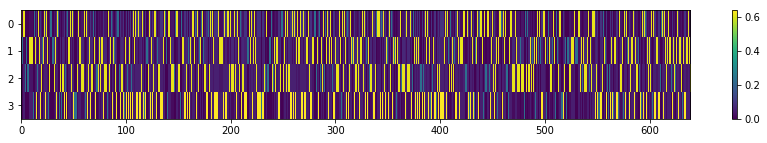

Count of indices in training
[(1, 134), (2, 119), (4, 122), (8, 115), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.09351502 0.05610901 0.05610901 0.6390193 ]
 [0.03740601 0.07481202 0.61719913 0.01825769]
 [0.018703   0.61719913 0.03740601 0.05477308]
 [0.61719913 0.018703   0.05610901 0.05477308]
 [0.23317684 0.         0.         0.        ]
 [0.         0.23317684 0.         0.        ]
 [0.         0.         0.23317684 0.        ]
 [0.         0.         0.         0.23317684]]
Columns marginal
[1. 1. 1. 1.]


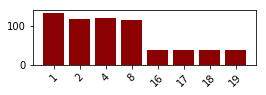

All training indices for the weak labels


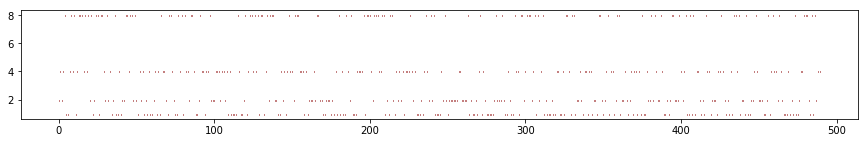

All training indices for the full set


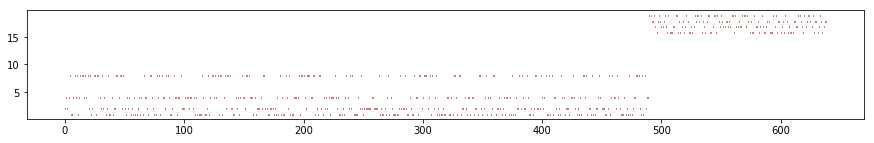

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.62 0.02 0.06 0.05]
 [0.   0.23 0.   0.  ]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.8663219338330927
CE = 0.9884537932532452
MSE = 0.2152974409467876
Acc. = 0.36619718309859156
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00555: early stopping
Number of weak samples = 490 and true = 149, Accuracy = 0.779


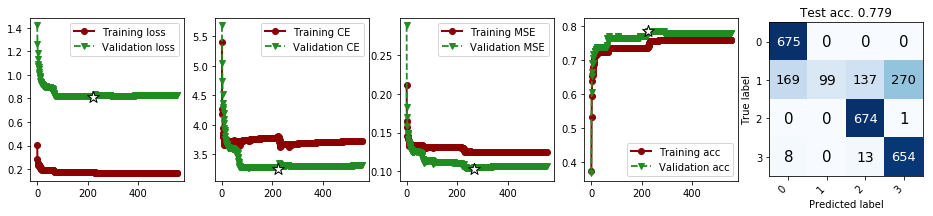

<Figure size 360x288 with 0 Axes>

Size set weak = 560, size set true = 149
q_0 = 0.7898448519040903, q_1 = 0.21015514809590974
[[0.         0.         0.         0.        ]
 [0.09632254 0.05779353 0.05779353 0.65820404]
 [0.03852902 0.07705803 0.63572878 0.01880583]
 [0.         0.         0.         0.        ]
 [0.01926451 0.63572878 0.03852902 0.05641749]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.63572878 0.01926451 0.05779353 0.05641749]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.21015515 0.         0.         0.        ]
 [0.         0.21015515 0.         0.        ]
 [0.         0.         0.21015515 0.        ]
 [0.         0

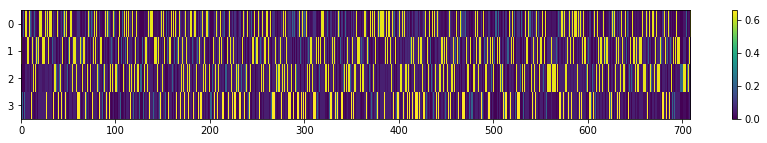

Count of indices in training
[(1, 122), (2, 149), (4, 148), (8, 141), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.09632254 0.05779353 0.05779353 0.65820404]
 [0.03852902 0.07705803 0.63572878 0.01880583]
 [0.01926451 0.63572878 0.03852902 0.05641749]
 [0.63572878 0.01926451 0.05779353 0.05641749]
 [0.21015515 0.         0.         0.        ]
 [0.         0.21015515 0.         0.        ]
 [0.         0.         0.21015515 0.        ]
 [0.         0.         0.         0.21015515]]
Columns marginal
[1. 1. 1. 1.]


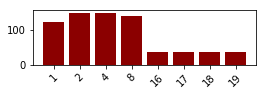

All training indices for the weak labels


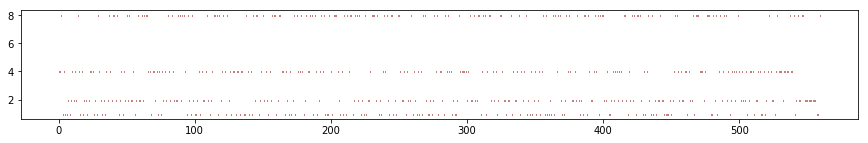

All training indices for the full set


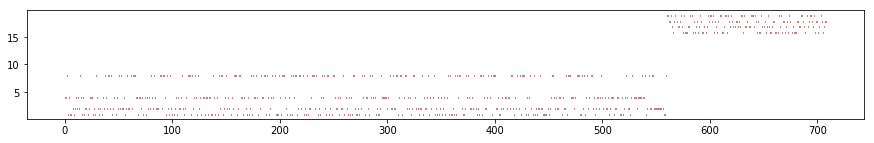

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.02 0.64 0.04 0.06]
 [0.   0.   0.   0.21]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.8197410733637919
CE = 0.9275972635831446
MSE = 0.20980999947347367
Acc. = 0.3935119887165021
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00938: early stopping
Number of weak samples = 560 and true = 149, Accuracy = 0.556


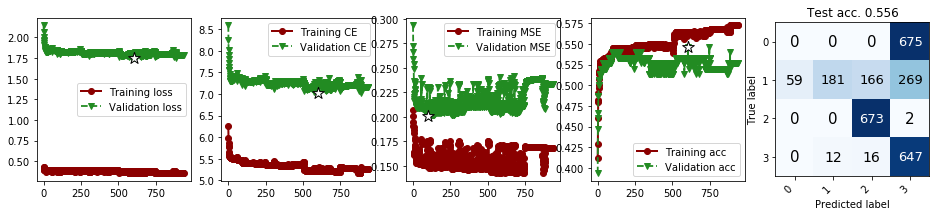

<Figure size 360x288 with 0 Axes>

Size set weak = 630, size set true = 149
q_0 = 0.8087291399229781, q_1 = 0.19127086007702182
[[0.         0.         0.         0.        ]
 [0.0986255  0.0591753  0.0591753  0.67394095]
 [0.0394502  0.0789004  0.65092833 0.01925546]
 [0.         0.         0.         0.        ]
 [0.0197251  0.65092833 0.0394502  0.05776637]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.65092833 0.0197251  0.0591753  0.05776637]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.19127086 0.         0.         0.        ]
 [0.         0.19127086 0.         0.        ]
 [0.         0.         0.19127086 0.        ]
 [0.         0

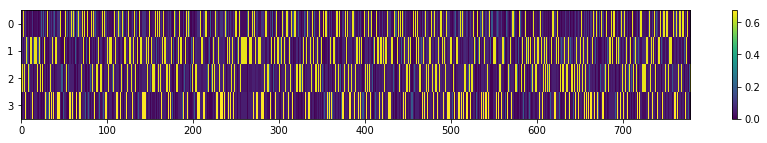

Count of indices in training
[(1, 156), (2, 154), (4, 175), (8, 145), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.0986255  0.0591753  0.0591753  0.67394095]
 [0.0394502  0.0789004  0.65092833 0.01925546]
 [0.0197251  0.65092833 0.0394502  0.05776637]
 [0.65092833 0.0197251  0.0591753  0.05776637]
 [0.19127086 0.         0.         0.        ]
 [0.         0.19127086 0.         0.        ]
 [0.         0.         0.19127086 0.        ]
 [0.         0.         0.         0.19127086]]
Columns marginal
[1. 1. 1. 1.]


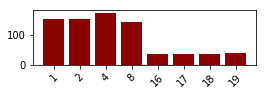

All training indices for the weak labels


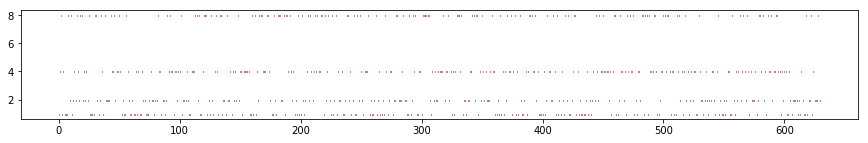

All training indices for the full set


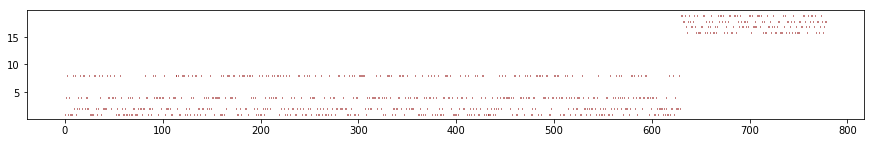

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.04 0.08 0.65 0.02]
 [0.04 0.08 0.65 0.02]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.8056611094509353
CE = 0.9012915187129558
MSE = 0.21792245093735038
Acc. = 0.36713735558408217
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01172: early stopping
Number of weak samples = 630 and true = 149, Accuracy = 0.589


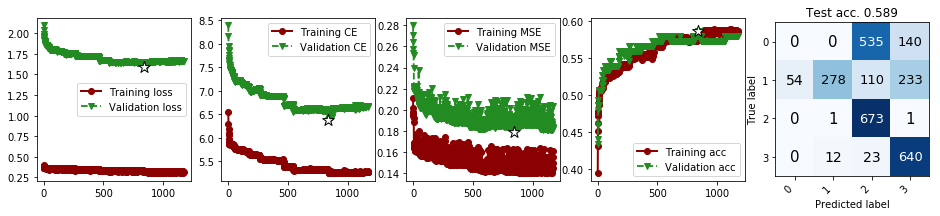

<Figure size 360x288 with 0 Axes>

Size set weak = 700, size set true = 149
q_0 = 0.8244994110718492, q_1 = 0.17550058892815076
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.66362148 0.02010974 0.06032923 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.17550059 0.         0.         0.        ]
 [0.         0.17550059 0.         0.        ]
 [0.         0.         0.17550059 0.        ]
 [0.         0

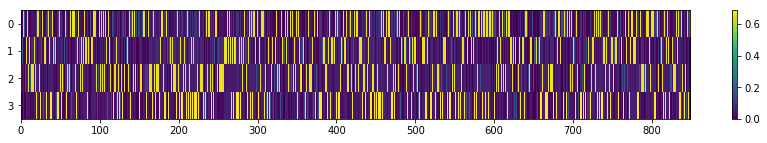

Count of indices in training
[(1, 174), (2, 173), (4, 165), (8, 188), (16, 37), (17, 37), (18, 37), (19, 38)]
Corresponding mixing matrix rows
[[0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.66362148 0.02010974 0.06032923 0.05889282]
 [0.17550059 0.         0.         0.        ]
 [0.         0.17550059 0.         0.        ]
 [0.         0.         0.17550059 0.        ]
 [0.         0.         0.         0.17550059]]
Columns marginal
[1. 1. 1. 1.]


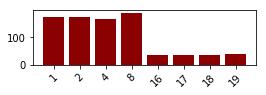

All training indices for the weak labels


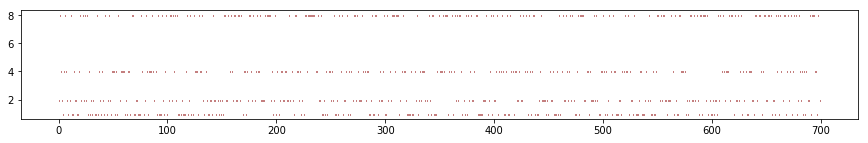

All training indices for the full set


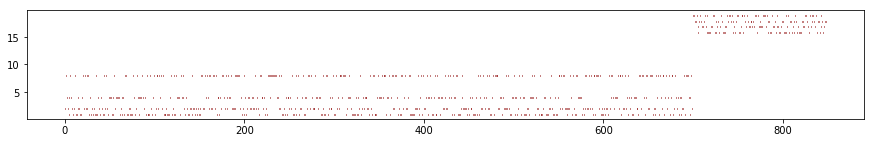

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.04 0.08 0.66 0.02]
 [0.   0.18 0.   0.  ]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.7895888851615172
CE = 0.8798200859383816
MSE = 0.22659164596480863
Acc. = 0.34393404004711425
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00860: early stopping
Number of weak samples = 700 and true = 149, Accuracy = 0.569


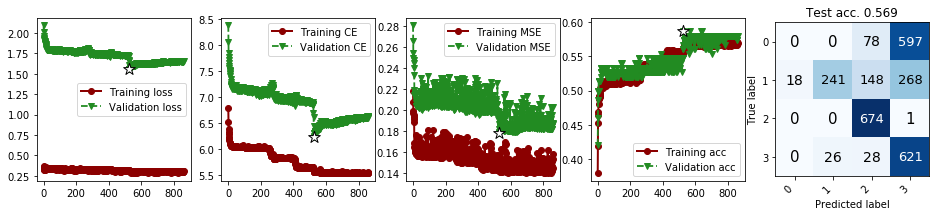

<Figure size 360x288 with 0 Axes>

In [17]:
Z_w_index = weak_to_index(Z_w, method='random_weak')
Y_wt_train_index = weak_to_index(Y_wt_train, method='supervised')

print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_train_index {}'.format(Y_wt_train_index[:5]))

method = 'EM M estimated'
print('Training {}'.format(method))
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_EM
print('Mixing matrix M shape = {}'.format(m[method].shape))
print(m[method])
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_w.shape[0])
    training_choice = numpy.random.choice(Z_w.shape[0], last_index)
    
    X_wt_aux = numpy.concatenate((X_w[training_choice], X_wt_train))
    ZY_wt_aux_index = numpy.concatenate((Z_w_index[training_choice], Y_wt_train_index + M_0.shape[0]))
    
    # Change weights q for the actual sizes
    q_0 = last_index / float(last_index + X_wt_train.shape[0])
    q_1 = X_wt_train.shape[0] / float(last_index + X_wt_train.shape[0])
    print("Size set weak = {:.0f}, size set true = {:.0f}".format(last_index, X_wt_train.shape[0]))
    print("q_0 = {}, q_1 = {}".format(q_0, q_1))
    m_aux = numpy.array(numpy.concatenate((q_0*M_0, q_1*M_1), axis=0))
    #m_aux = M_EM # numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
    
    print(m_aux)
    ZY_wt_aux = m_aux[ZY_wt_aux_index]
    
    X_wt_aux, ZY_wt_aux = shuffle(X_wt_aux, ZY_wt_aux)
    
    print('Training objective scores')
    fig = plt.figure(figsize=(15, 2))
    plt.imshow(ZY_wt_aux.T, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.show()

    from collections import Counter
    c = Counter(ZY_wt_aux_index)
    c = sorted(c.items())
    print('Count of indices in training')
    print(c)
    print('Corresponding mixing matrix rows')
    print(m_aux[[x[0] for x in c]])
    print('Columns marginal')
    print(m_aux[[x[0] for x in c]].sum(axis=0))
    fig = plt.figure(figsize=(4, 1))
    ax = fig.add_subplot(111)
    _ = ax.bar(range(len(c)), [x[1] for x in c])
    _ = ax.set_xticks(range(len(c)))
    _ = ax.set_xticklabels([x[0] for x in c], rotation=45)
    plt.show()

    print('All training indices for the weak labels')
    fig = plt.figure(figsize=(15, 2))
    plt.scatter(range(last_index), Z_w_index[training_choice], marker='|', s=1)
    plt.show()
    
    print('All training indices for the full set')
    fig = plt.figure(figsize=(15, 2))
    plt.scatter(range(len(ZY_wt_aux_index)), ZY_wt_aux_index, marker='|', s=1)
    plt.show()
    
    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    print('Sample of train labels = {}'.format(numpy.round(ZY_wt_aux[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    print('Training set intial performance')
    print_performance(model, X_wt_aux, ZY_wt_aux)
    print('Validation set intial performance')
    print_performance(model, X_wt_val, Y_wt_val)
    history = model.fit(X_wt_aux, ZY_wt_aux, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} and true = {}, Accuracy = {:.3f}'.format(last_index, X_wt_train.shape[0], acc[method][i]))

    
    plot_results(model, X_wt_test, y_wt_test, history)
    plt.show()

## 3.d. Training with virtual labels

Z_w_index = weak_to_index(Z_w, method='random_weak')
Y_wt_train_index = weak_to_index(Y_wt_train, method='supervised')

print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_train_index {}'.format(Y_wt_train_index[:5]))

method = 'Virtual M estimated'
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_EM
print('Mixing matrix M shape = {}'.format(m[method].shape))
print(m[method])
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_w.shape[0])
    
    X_wt_aux = numpy.concatenate((X_w[:last_index], X_wt_train))
    ZY_wt_aux_index = numpy.concatenate((Z_w_index[:last_index], Y_wt_train_index + M_0.shape[0]))
    
    # Change weights q for the actual sizes
    q_0 = last_index / float(last_index + X_wt_train.shape[0])
    q_1 = X_wt_train.shape[0] / float(last_index + X_wt_train.shape[0])
    print("Size set weak = {:.0f}, size set true = {:.0f}".format(last_index, X_wt_train.shape[0]))
    print("q_0 = {}, q_1 = {}".format(q_0, q_1))
    m_aux = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
    #m_aux = M_EM # numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
    
        
    V_aux = numpy.linalg.pinv(m_aux)
    print(V_aux)
    
    ZY_wt_aux = V_aux.T[ZY_wt_aux_index]
    
    #print(m_aux)
    #ZY_wt_aux = m_aux[ZY_wt_aux_index]

    numpy.random.seed(random_state)
    model = make_model('mse')

    print('Sample of train labels = {}'.format(numpy.round(ZY_wt_aux[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    history = model.fit(X_wt_aux, ZY_wt_aux, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} and true = {}, Accuracy = {:.3f}'.format(last_index, X_wt_train.shape[0], acc[method][i]))

    
    plot_results(model, X_wt_test, y_wt_test, history)

## 4. Baseline Optimistic Superset Learning

- uses the predictions for the weak labels
- **TODO** This function assumes there are no fully unsupervised samples!!! The current approach will assign 1/n_zeros as the weak label (this may not be bad, if we assume that it needs to belong to one of the classes).

Training OSL
Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01292: early stopping
Number of weak samples = 70 from total 219, Accuracy = 0.781


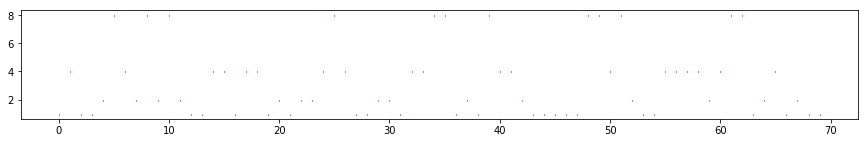

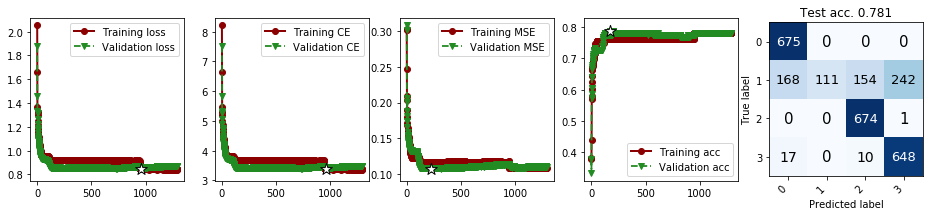

<Figure size 360x288 with 0 Axes>

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01275: early stopping
Number of weak samples = 140 from total 289, Accuracy = 0.788


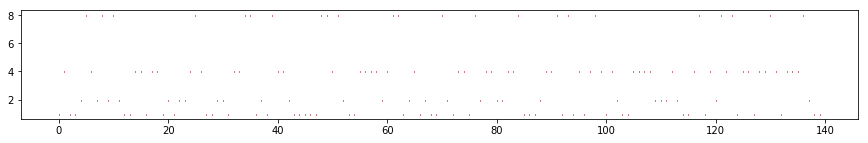

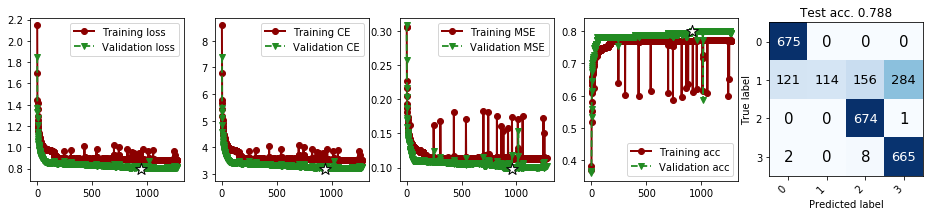

<Figure size 360x288 with 0 Axes>

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01191: early stopping
Number of weak samples = 210 from total 359, Accuracy = 0.794


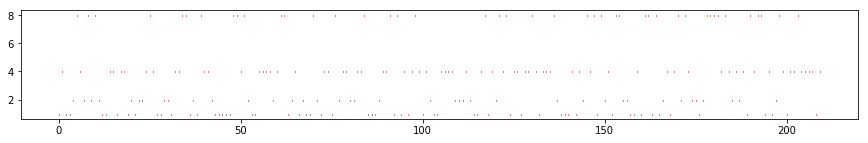

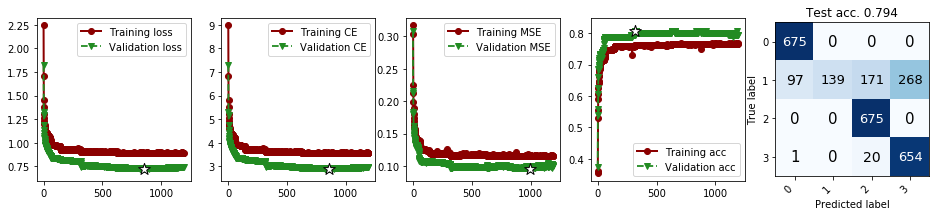

<Figure size 360x288 with 0 Axes>

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01186: early stopping
Number of weak samples = 280 from total 429, Accuracy = 0.793


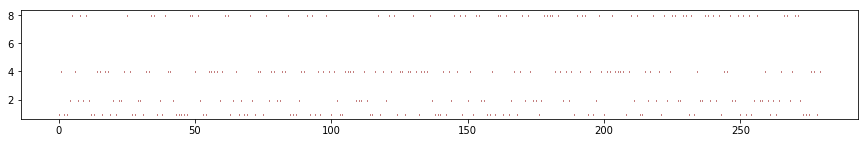

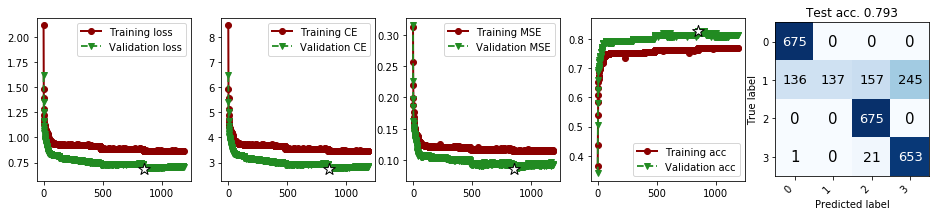

<Figure size 360x288 with 0 Axes>

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01070: early stopping
Number of weak samples = 350 from total 499, Accuracy = 0.817


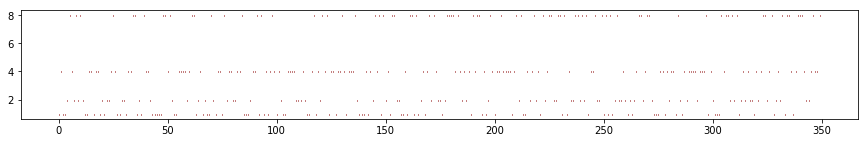

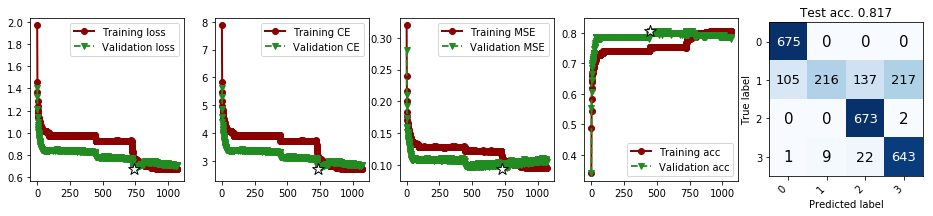

<Figure size 360x288 with 0 Axes>

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 00645: early stopping
Number of weak samples = 420 from total 569, Accuracy = 0.804


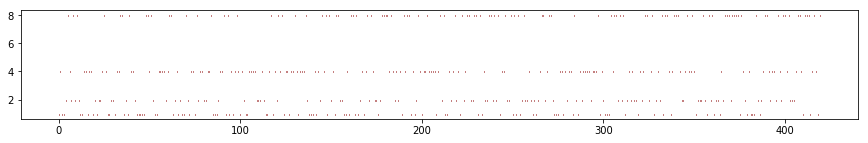

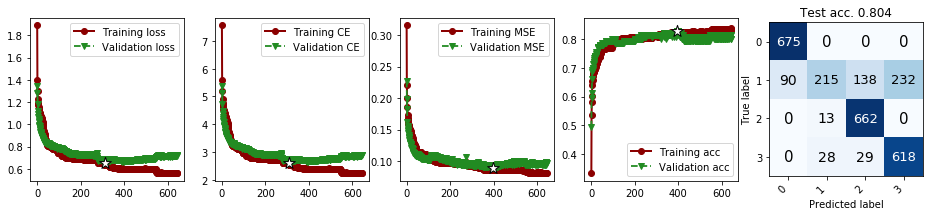

<Figure size 360x288 with 0 Axes>

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01925: early stopping
Number of weak samples = 490 from total 639, Accuracy = 0.860


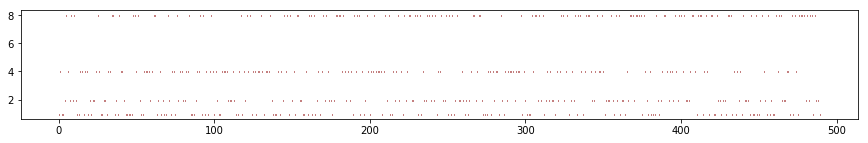

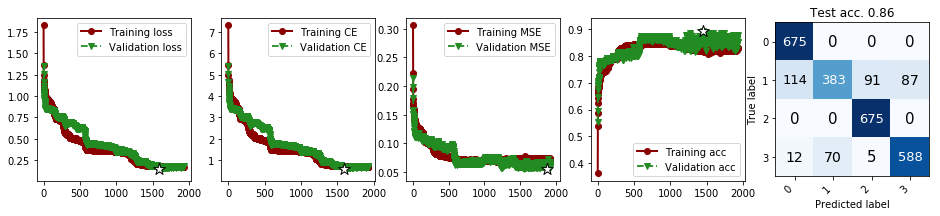

<Figure size 360x288 with 0 Axes>

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01738: early stopping
Number of weak samples = 560 from total 709, Accuracy = 0.869


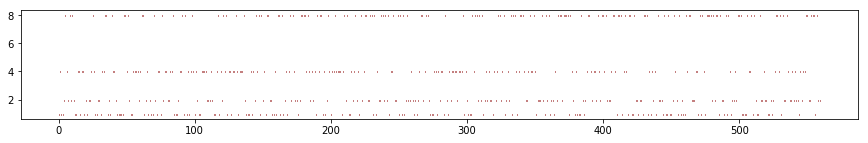

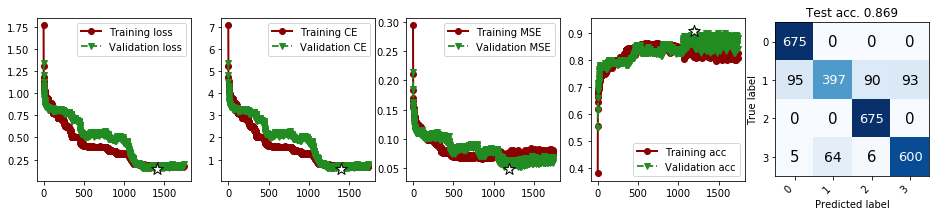

<Figure size 360x288 with 0 Axes>

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01512: early stopping
Number of weak samples = 630 from total 779, Accuracy = 0.873


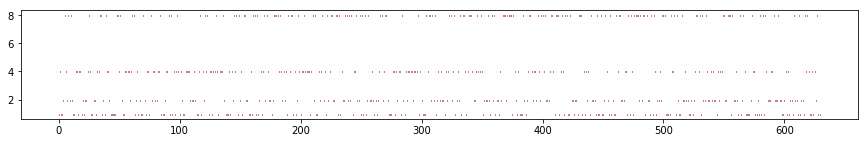

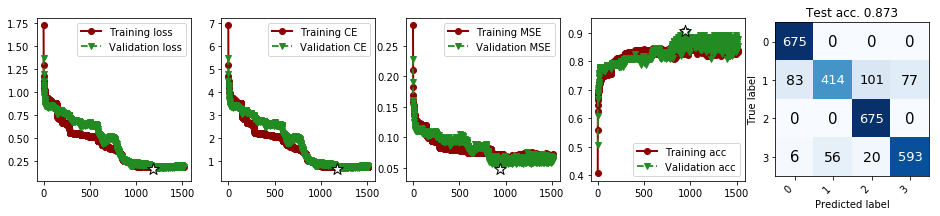

<Figure size 360x288 with 0 Axes>

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0 0 0 1]
 [0 1 0 0]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Restoring model weights from the end of the best epoch
Epoch 01048: early stopping
Number of weak samples = 700 from total 849, Accuracy = 0.880


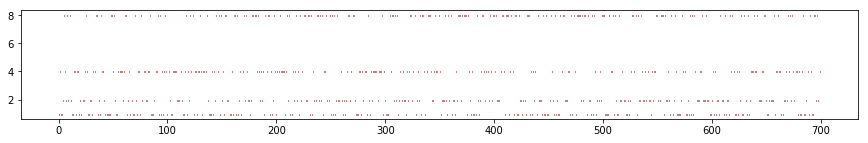

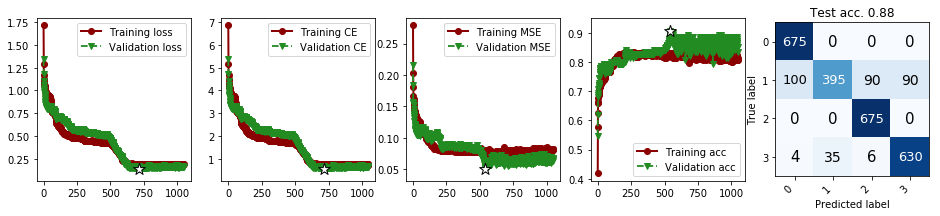

<Figure size 360x288 with 0 Axes>

In [18]:
def OSL_log_loss(y_true, y_pred):
    # Careful, I had to use a global variable here for the number of classes
    # for some reason I can not use y_osl.shape[-1] in the reshape function
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    y_osl = y_true * y_pred
    y_osl_max = K.max(y_osl, axis=-1)
    y_osl_max = K.repeat_elements(y_osl_max, n_classes, 0)
    y_osl_max = K.reshape(y_osl_max, (-1, n_classes))
    y_osl = K.cast(K.equal(y_osl, y_osl_max), y_pred.dtype)
    y_osl = y_osl / K.sum(y_osl, axis=-1, keepdims=True)
    out = -K.stop_gradient(y_osl) * K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'OSL'
print('Training {}'.format(method))

acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_w.shape[0])
    
    X_aux_train = numpy.concatenate((X_w[:last_index], X_wt_train))
    Z_aux_train = numpy.concatenate((Z_w[:last_index], Y_wt_train))
    
    fig = plt.figure(figsize=(15, 2))
    plt.scatter(range(last_index), Z_w_index[:last_index], marker='|', s=1)

    numpy.random.seed(random_state)
    model = make_model(OSL_log_loss)


    print('Sample of train labels = {}'.format(numpy.round(Z_aux_train[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    history = model.fit(X_aux_train, Z_aux_train, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} from total {}, Accuracy = {:.3f}'.format(last_index, X_aux_train.shape[0], acc[method][i]))
    
    plot_results(model, X_wt_test, y_wt_test, history)
    plt.show()

# 5. Save results

In [19]:
import pandas
weak_proportions = numpy.array(list_weak_proportions)*Z_w.shape[0]

df_experiment = pandas.DataFrame.from_dict(
    dict(random_state=random_state,
         dataset_name=dataset_name,
         n_samples=n_samples,
         n_features=n_features,
         M_method=M_method,
         M_alpha=M_alpha,
         M_beta=M_beta,
         weak_proportions=weak_proportions,
         acc_methods=acc,
         acc_upperbound=acc_upperbound,
         acc_lowerbound=acc_lowerbound,
         n_w_samples = n_w_samples,
         n_t_samples = n_t_samples,
         n_wt_samples_train = n_wt_samples_train,
         n_wt_samples_val = n_wt_samples_val,
         n_wt_samples_test = n_wt_samples_test,
         n_wt_samples = n_wt_samples,
        ), orient='index')
print(df_experiment)
if M_method is not None:
    M_text = '_{}_a{:02.0f}_b{:02.0f}'.format(M_method, 10*M_alpha, 10*M_beta)
else:
    M_text = ''
filename = 'full_vs_em_{}_{}_{}{}'.format(random_state, dataset_name, n_wt_samples_train, M_text)
df_experiment.to_json(filename + '.json')

                                                                    0
random_state                                                        0
dataset_name                                                    blobs
n_samples                                                       10000
n_features                                                         30
M_method                                                        noisy
M_alpha                                                             1
M_beta                                                            0.1
weak_proportions    [70.0, 140.0, 210.0, 280.0, 350.0, 420.0, 490....
acc_methods         {'True': [0.7644444444444445, 0.77222222222222...
acc_upperbound                                               0.898519
acc_lowerbound                                               0.761481
n_w_samples                                                      7000
n_t_samples                                                         0
n_wt_samples_train  

## 5.b. Update saved results

In [20]:
df_experiment = pandas.read_json(filename + '.json')
locals().update(df_experiment)

# 6. Plot results

Acc. Upperbound = 0.8985185185185185
Acc. True
[0.76444444 0.77222222 0.7962963  0.80185185 0.78333333 0.81814815
 0.86037037 0.86592593 0.83740741 0.86814815]
Acc. Weak
[0.78074074 0.79444444 0.7937037  0.79259259 0.81296296 0.8037037
 0.85962963 0.86666667 0.87296296 0.87962963]
Acc. EM M original
[0.76222222 0.76185185 0.52259259 0.80666667 0.55666667 0.54777778
 0.60666667 0.5662963  0.82518519 0.83814815]
Acc. EM M estimated
[0.78592593 0.51148148 0.58962963 0.58037037 0.57333333 0.30185185
 0.36296296 0.33888889 0.81666667 0.57518519]
Acc. OSL
[0.78074074 0.78814815 0.7937037  0.79259259 0.81740741 0.8037037
 0.85962963 0.86925926 0.87296296 0.87962963]
Acc. Lowerbound = 0.7614814814814815
Saved figure as full_vs_em_0_blobs_149_noisy_a10_b01.svg


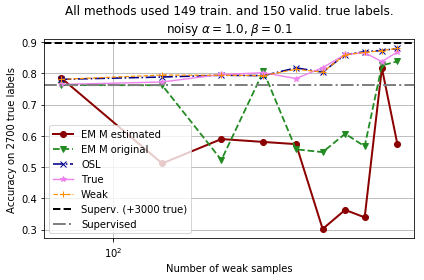

In [37]:
weak_proportions = numpy.array(list_weak_proportions)*Z_w.shape[0]

if acc_upperbound is not None:
    print('Acc. Upperbound = {}'.format(acc_upperbound))
for key, value in acc.items():
    print('Acc. {}\n{}'.format(key, value))
print('Acc. Lowerbound = {}'.format(acc_lowerbound))

fig = plt.figure()
ax = fig.add_subplot(111)
if M_method is not None:
    M_text = "\n" + r"{} $\alpha={:0.1f}$, $\beta={:0.1f}$".format(M_method, M_alpha, M_beta)
else:
    M_text = ''
ax.set_title("All methods used {} train. and {} valid. true labels.{}".format(
    n_wt_samples_train, n_wt_samples_val, M_text))
for key, value in sorted(acc.items()):
    ax.plot(weak_proportions, value, label='{}'.format(key, n_wt_samples_train))
if acc_upperbound is not None:
    ax.axhline(y=acc_upperbound, color='black', lw=2,linestyle='--', label='Superv. (+{} true)'.format(n_wt_samples))
ax.axhline(y=acc_lowerbound, color='gray', lw=2, linestyle='-.', label='Supervised')
ax.set_xlabel('Number of weak samples')
ax.set_ylabel('Accuracy on {} true labels'.format(n_wt_samples_test))
ax.set_xscale("symlog")
ax.legend(loc=0, fancybox=True, framealpha=0.8)
ax.grid()
fig.tight_layout()
fig.savefig(filename + '.svg')
print('Saved figure as {}.svg'.format(filename))

# Debug for known M

Z_w_index [3 1 3 3 2]
Y_wt_train_index [3 3 2 2 3]
Training EM M original
Mixing matrix M shape = (8, 4)
[[0.88124213 0.0326386  0.0326386  0.0326386 ]
 [0.0326386  0.88124213 0.0326386  0.0326386 ]
 [0.0326386  0.0326386  0.88124213 0.0326386 ]
 [0.0326386  0.0326386  0.0326386  0.88124213]
 [0.02084208 0.         0.         0.        ]
 [0.         0.02084208 0.         0.        ]
 [0.         0.         0.02084208 0.        ]
 [0.         0.         0.         0.02084208]]
Training objective scores


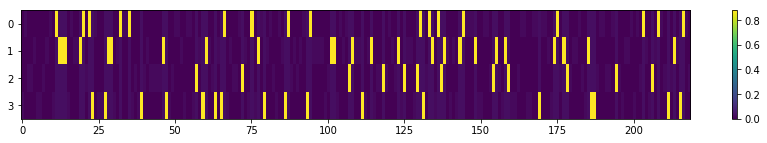

Count of indices in training
[(0, 17), (1, 24), (2, 12), (3, 17), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


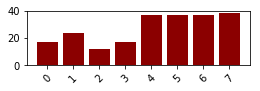

All training indices for the weak labels


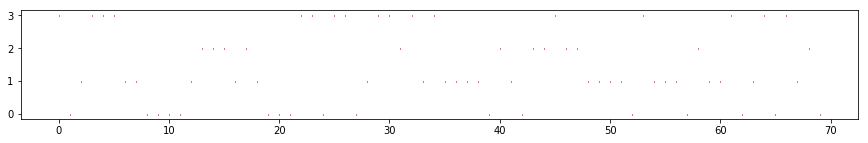

All training indices for the full set


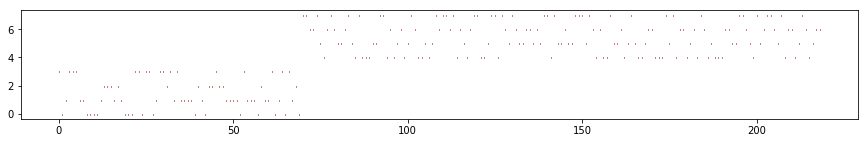

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.   0.   0.   0.02]
 [0.02 0.   0.   0.  ]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.8758165848819348
CE = 2.0843266453007327
MSE = 0.26537258301488087
Acc. = 0.3607305936073059
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00464: early stopping
Number of weak samples = 70 and true = 149, Accuracy = 0.762
(464, 30, 4)


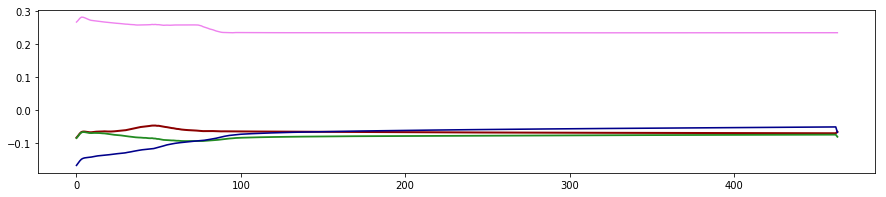

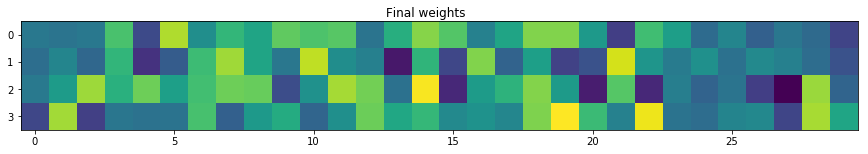

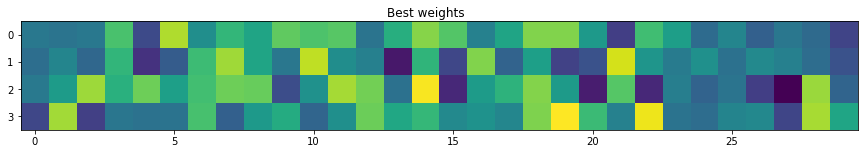

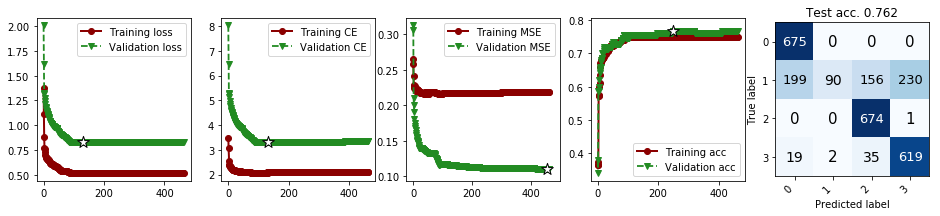

<Figure size 360x288 with 0 Axes>

Training objective scores


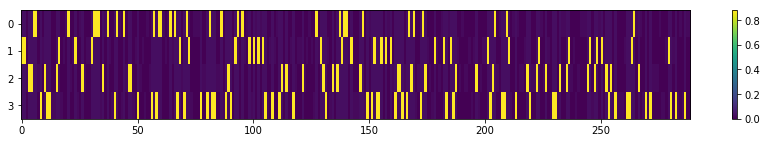

Count of indices in training
[(0, 30), (1, 31), (2, 33), (3, 46), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


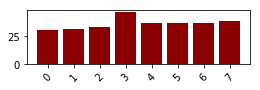

All training indices for the weak labels


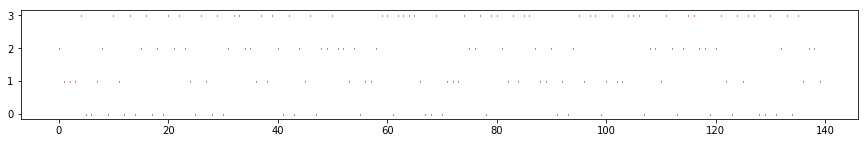

All training indices for the full set


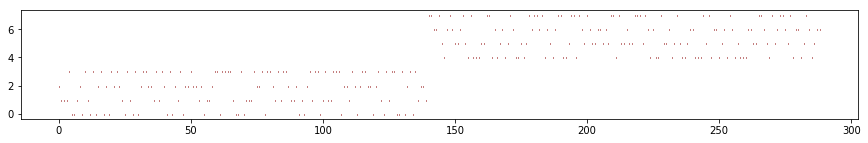

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.03 0.88 0.03 0.03]
 [0.03 0.88 0.03 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.5228369432661208
CE = 1.6877904742835732
MSE = 0.2512036181730453
Acc. = 0.3944636678200692
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00671: early stopping
Number of weak samples = 140 and true = 149, Accuracy = 0.762
(671, 30, 4)


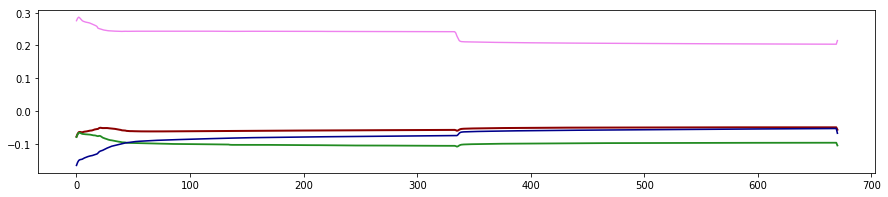

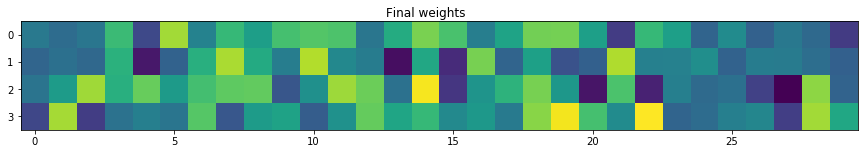

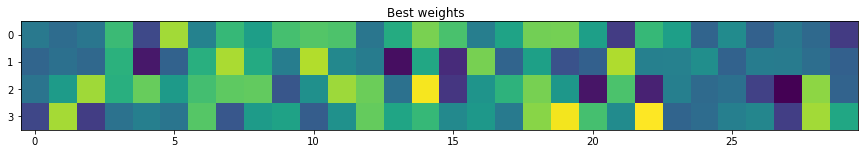

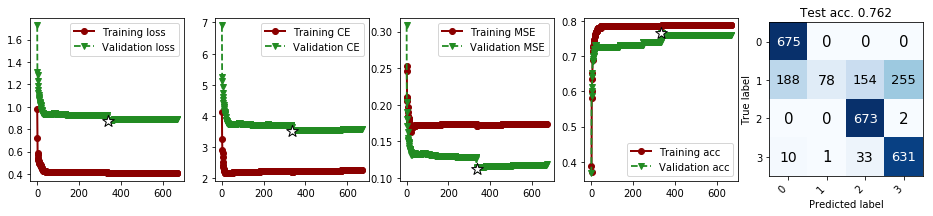

<Figure size 360x288 with 0 Axes>

Training objective scores


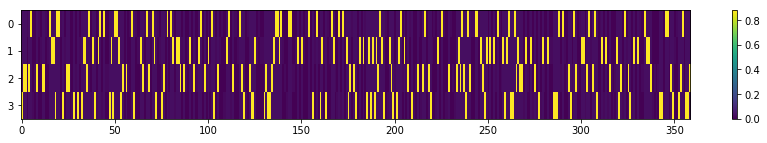

Count of indices in training
[(0, 49), (1, 56), (2, 53), (3, 52), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


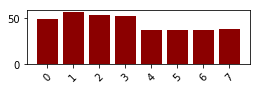

All training indices for the weak labels


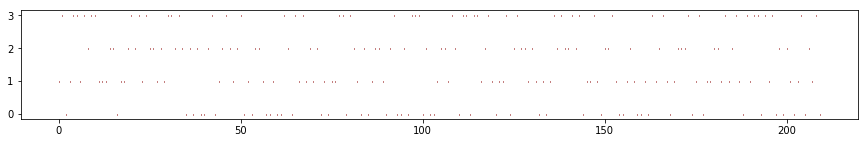

All training indices for the full set


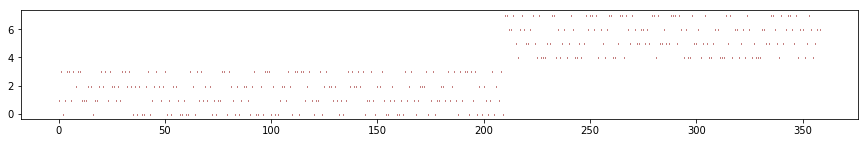

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.03 0.03 0.03 0.88]
 [0.03 0.03 0.88 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.3566152958727535
CE = 1.4903234700105734
MSE = 0.26891204709595307
Acc. = 0.3593314763231198
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00423: early stopping
Number of weak samples = 210 and true = 149, Accuracy = 0.523
(423, 30, 4)


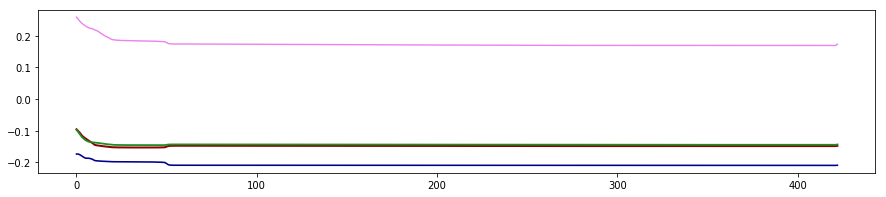

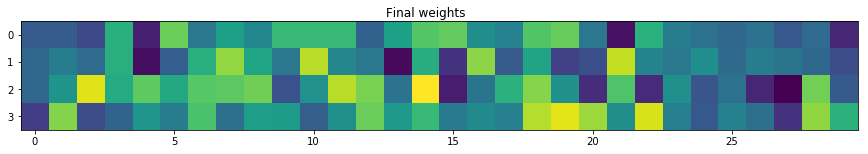

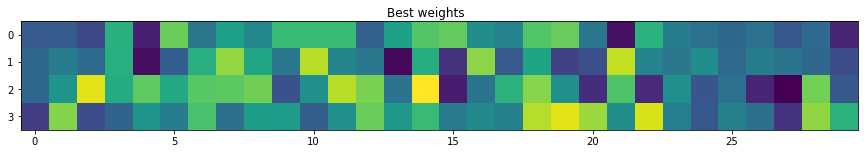

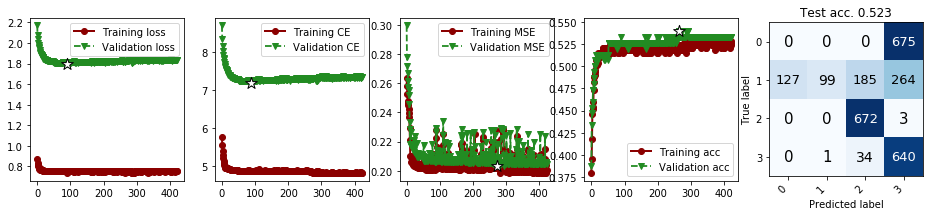

<Figure size 360x288 with 0 Axes>

Training objective scores


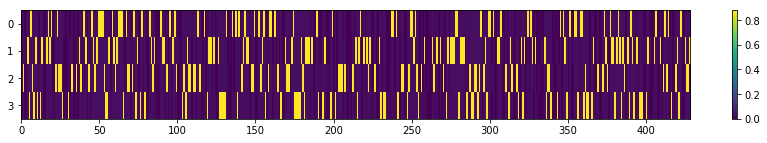

Count of indices in training
[(0, 68), (1, 79), (2, 67), (3, 66), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


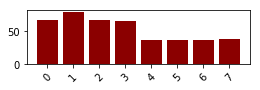

All training indices for the weak labels


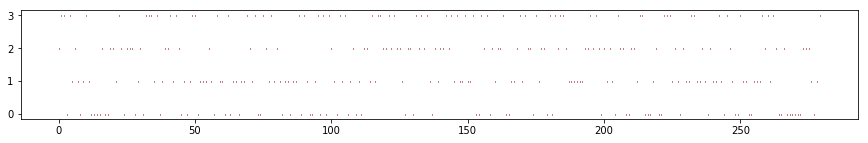

All training indices for the full set


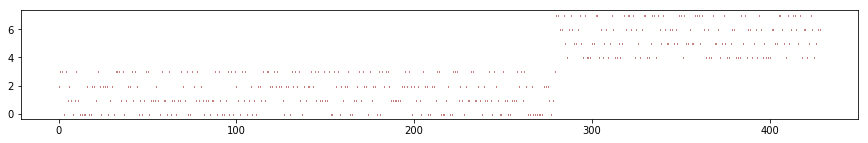

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.   0.   0.02 0.  ]
 [0.03 0.03 0.88 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.228346692439414
CE = 1.3446299304876395
MSE = 0.27143928178040433
Acc. = 0.3543123543123543
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01162: early stopping
Number of weak samples = 280 and true = 149, Accuracy = 0.807
(1162, 30, 4)


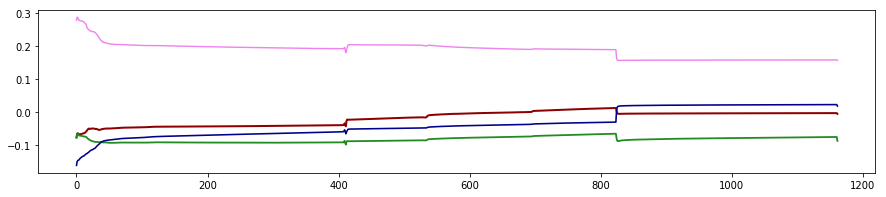

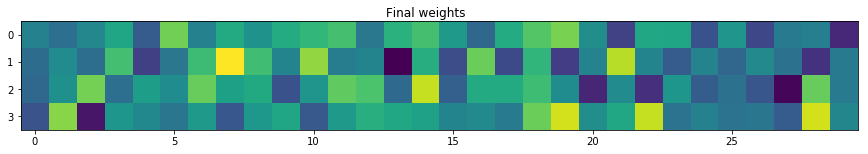

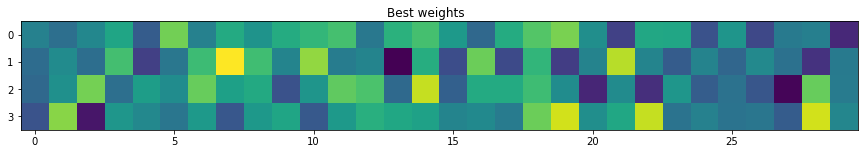

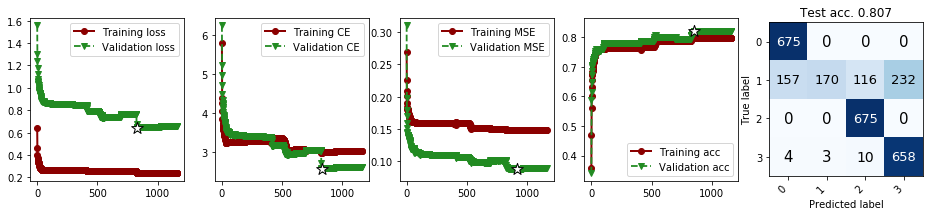

<Figure size 360x288 with 0 Axes>

Training objective scores


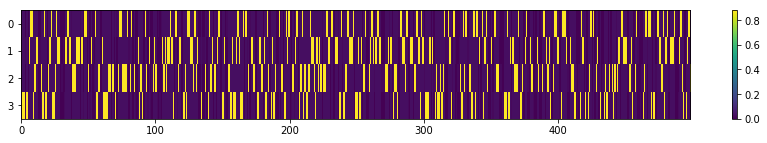

Count of indices in training
[(0, 82), (1, 96), (2, 93), (3, 79), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


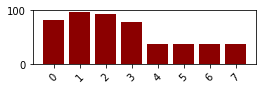

All training indices for the weak labels


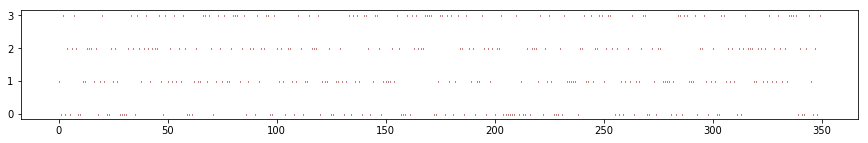

All training indices for the full set


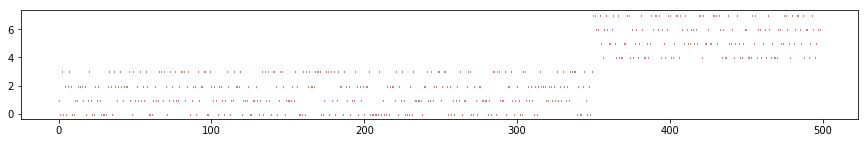

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.02 0.   0.   0.  ]
 [0.03 0.03 0.03 0.88]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.117415938850148
CE = 1.2197322381616404
MSE = 0.26322986305800905
Acc. = 0.37074148296593185
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00943: early stopping
Number of weak samples = 350 and true = 149, Accuracy = 0.557
(943, 30, 4)


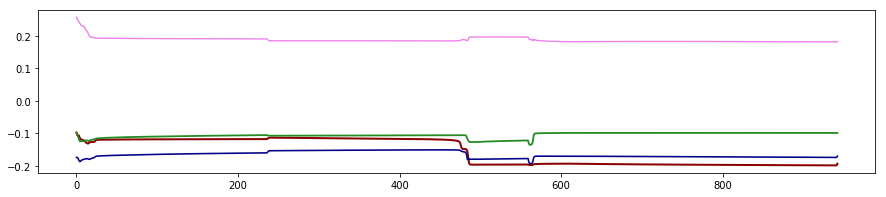

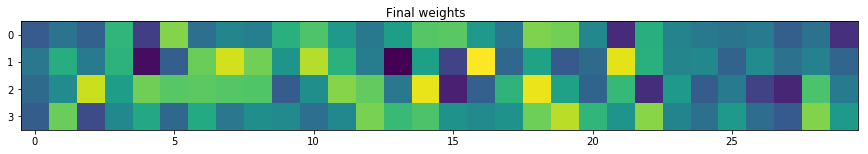

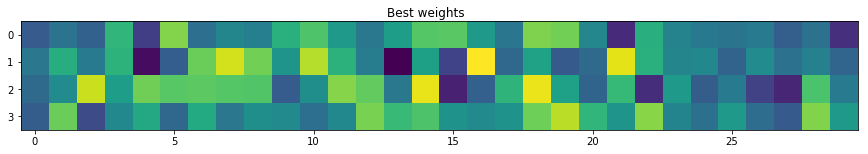

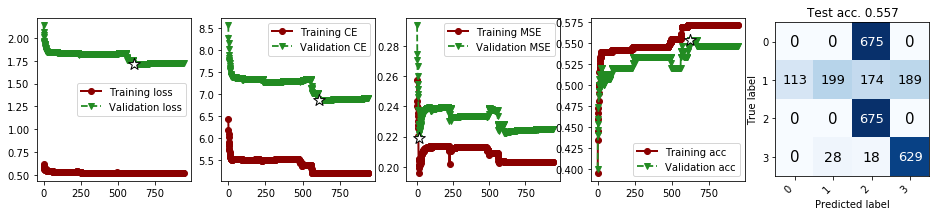

<Figure size 360x288 with 0 Axes>

Training objective scores


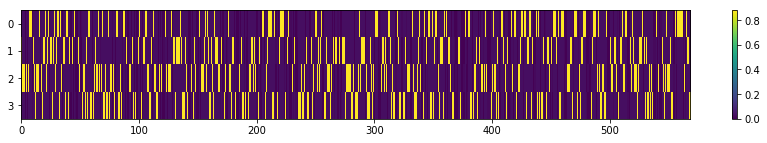

Count of indices in training
[(0, 96), (1, 98), (2, 112), (3, 114), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


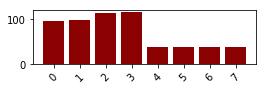

All training indices for the weak labels


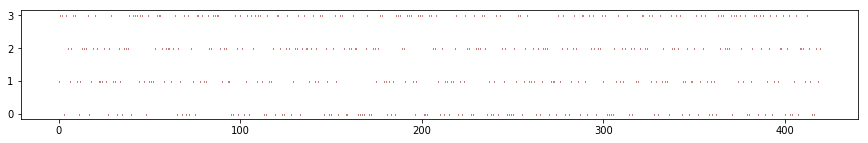

All training indices for the full set


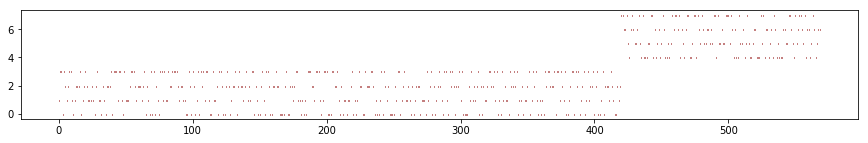

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.03 0.88 0.03 0.03]
 [0.03 0.03 0.88 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 1.0201670676529704
CE = 1.1139306978783194
MSE = 0.2510049116651249
Acc. = 0.4007029876977153
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01095: early stopping
Number of weak samples = 420 and true = 149, Accuracy = 0.548
(1095, 30, 4)


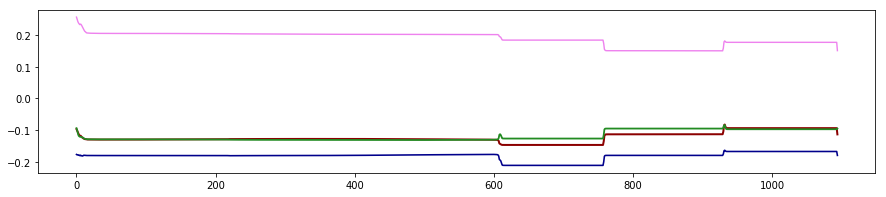

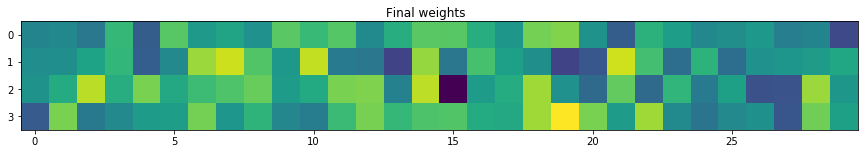

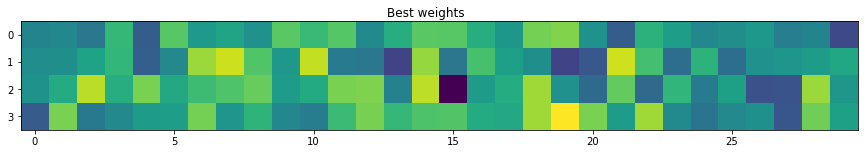

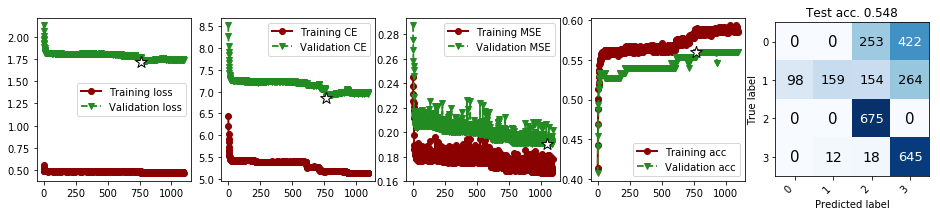

<Figure size 360x288 with 0 Axes>

Training objective scores


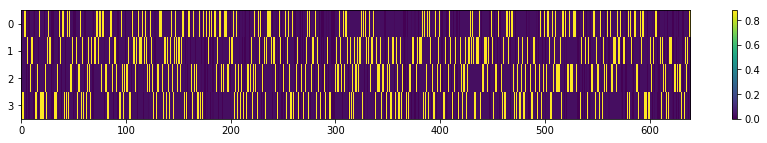

Count of indices in training
[(0, 113), (1, 128), (2, 127), (3, 122), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


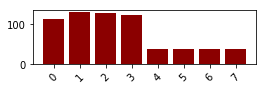

All training indices for the weak labels


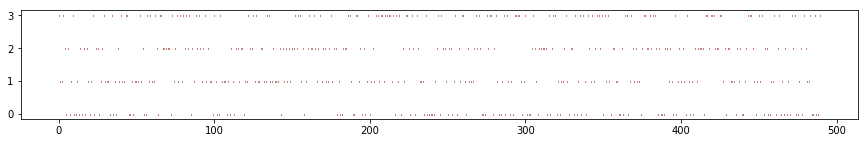

All training indices for the full set


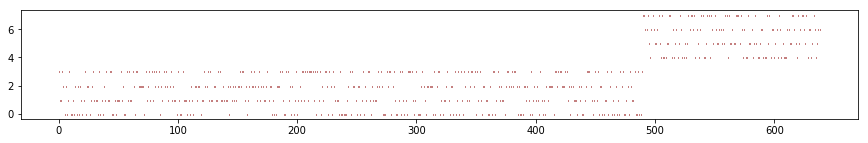

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.02 0.   0.   0.  ]
 [0.03 0.03 0.03 0.88]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.9908262877856557
CE = 1.0789943924755867
MSE = 0.26663860552078056
Acc. = 0.3646322378716745
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01159: early stopping
Number of weak samples = 490 and true = 149, Accuracy = 0.607
(1159, 30, 4)


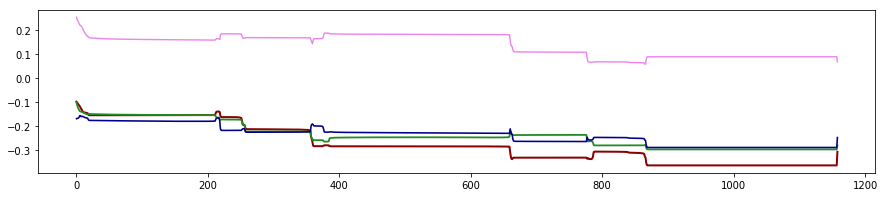

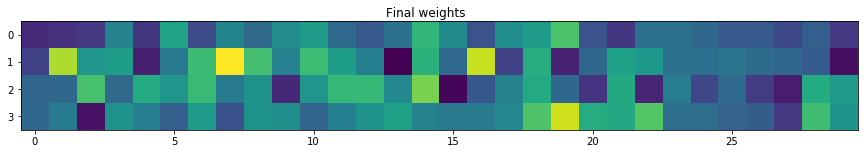

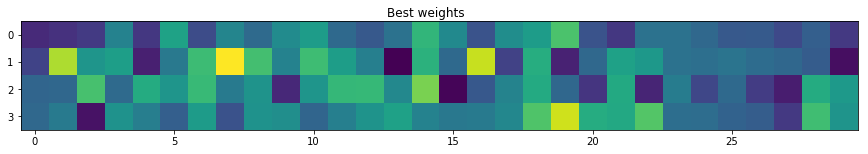

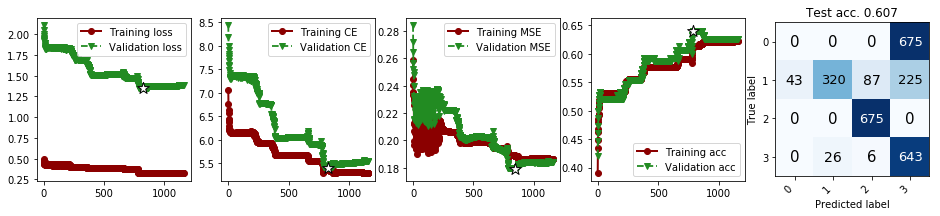

<Figure size 360x288 with 0 Axes>

Training objective scores


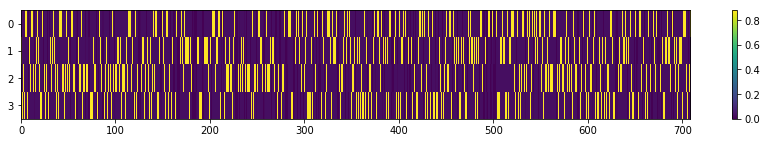

Count of indices in training
[(0, 137), (1, 138), (2, 150), (3, 135), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


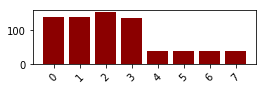

All training indices for the weak labels


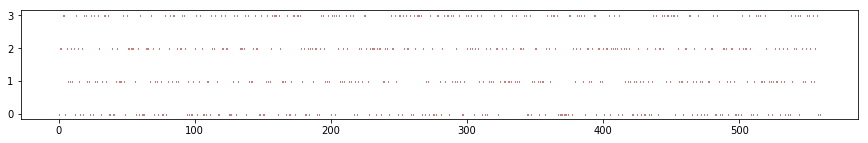

All training indices for the full set


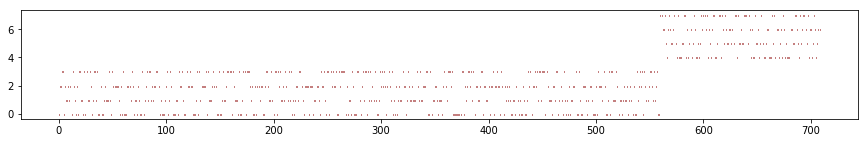

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.03 0.88 0.03 0.03]
 [0.03 0.03 0.03 0.88]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.9361873958837068
CE = 1.0144662757767458
MSE = 0.2612424060716345
Acc. = 0.37940761636107195
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00925: early stopping
Number of weak samples = 560 and true = 149, Accuracy = 0.566
(925, 30, 4)


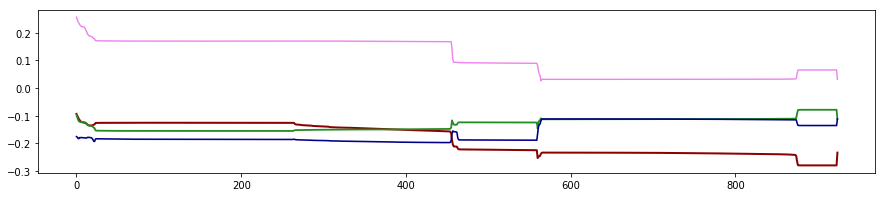

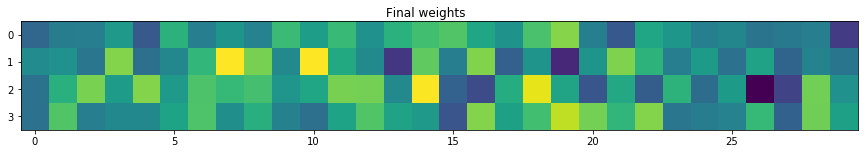

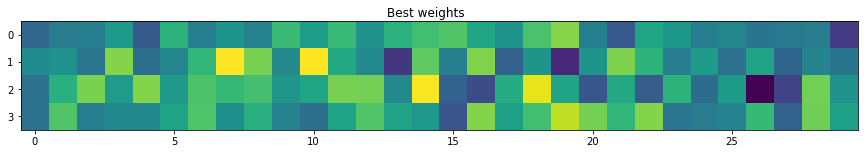

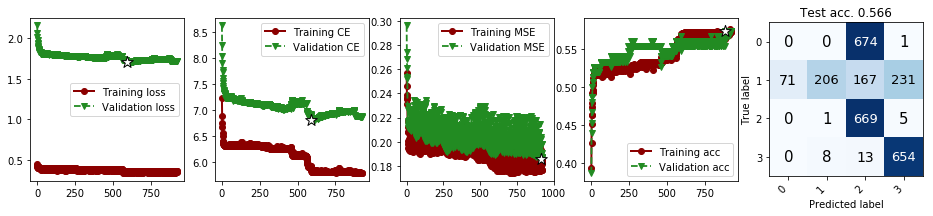

<Figure size 360x288 with 0 Axes>

Training objective scores


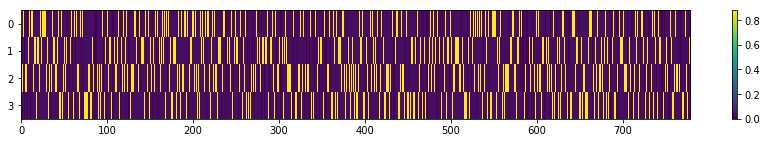

Count of indices in training
[(0, 150), (1, 157), (2, 176), (3, 147), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


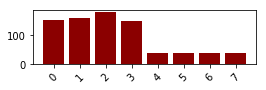

All training indices for the weak labels


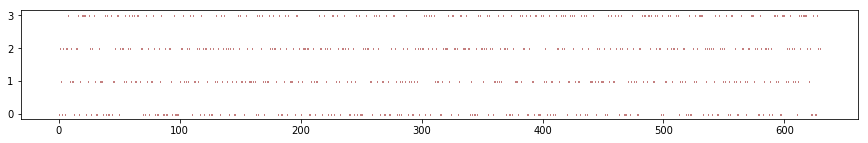

All training indices for the full set


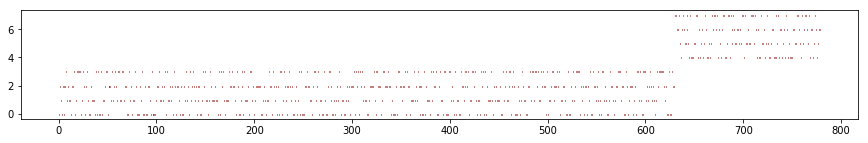

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.88 0.03 0.03 0.03]
 [0.03 0.03 0.88 0.03]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.8978169563423701
CE = 0.9720401188779991
MSE = 0.25970327319132
Acc. = 0.38254172015404364
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 01323: early stopping
Number of weak samples = 630 and true = 149, Accuracy = 0.825
(1323, 30, 4)


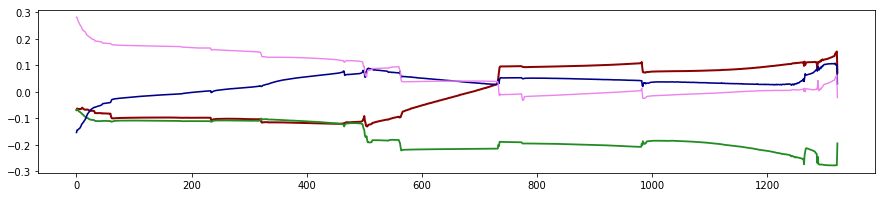

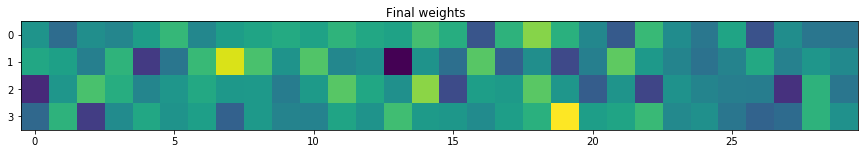

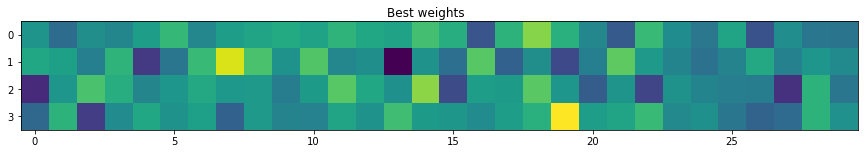

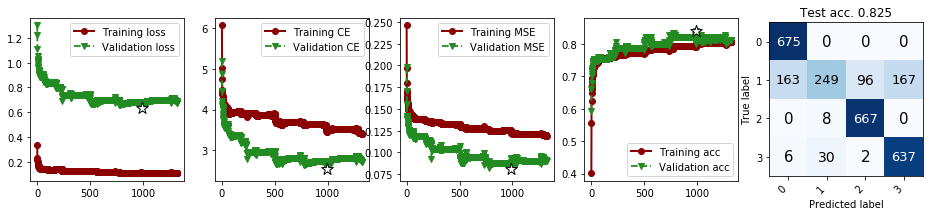

<Figure size 360x288 with 0 Axes>

Training objective scores


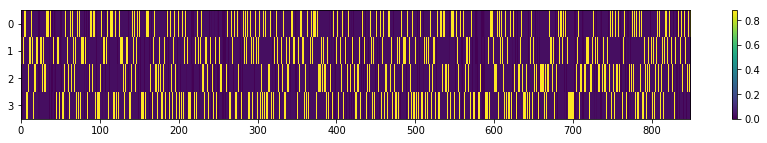

Count of indices in training
[(0, 163), (1, 180), (2, 156), (3, 201), (4, 37), (5, 37), (6, 37), (7, 38)]
Corresponding mixing matrix rows
[[0.         0.         0.         0.        ]
 [0.10054871 0.06032923 0.06032923 0.68708284]
 [0.04021948 0.08043897 0.66362148 0.01963094]
 [0.         0.         0.         0.        ]
 [0.02010974 0.66362148 0.04021948 0.05889282]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Columns marginal
[0.16087793 0.80438967 0.76417019 0.7656066 ]


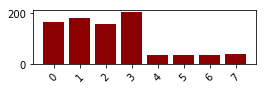

All training indices for the weak labels


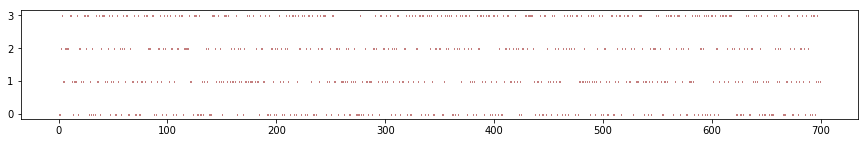

All training indices for the full set


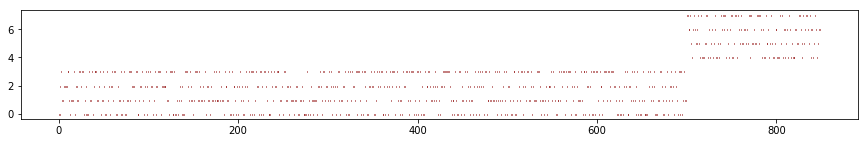

Sample of first weights = [-0.087 -0.13   0.004 -0.35 ]
Sample of train labels = [[0.03 0.88 0.03 0.03]
 [0.   0.   0.02 0.  ]]
Sample of validation labels = [[0 0 0 1]
 [0 1 0 0]]
Training set intial performance
EM = 0.8852431855010219
CE = 0.9564105272092097
MSE = 0.27029306931262437
Acc. = 0.3545347467608952
Validation set intial performance
EM = 1.686859770127126
CE = 2.5036246828339017
MSE = 0.30524648027856804
Acc. = 0.38
Restoring model weights from the end of the best epoch
Epoch 00901: early stopping
Number of weak samples = 700 and true = 149, Accuracy = 0.838
(901, 30, 4)


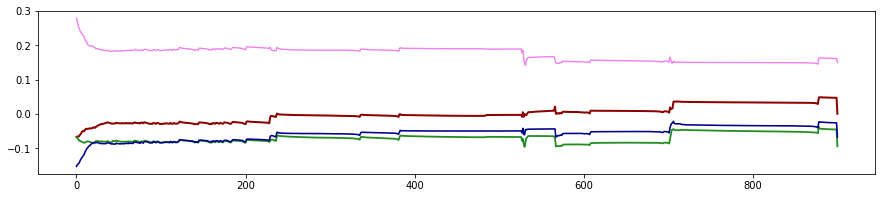

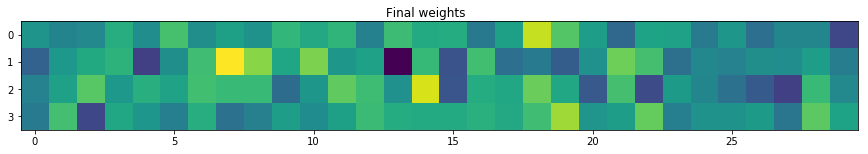

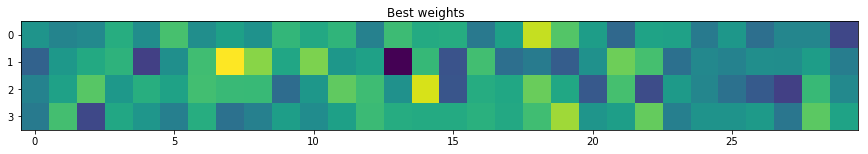

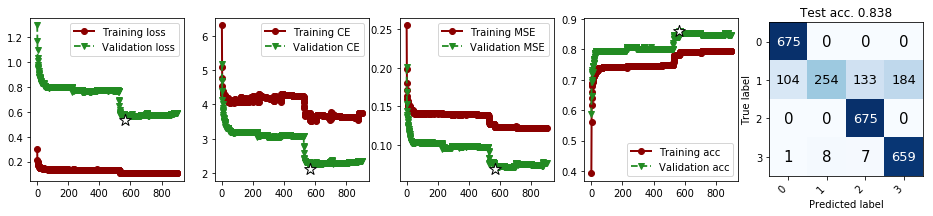

<Figure size 360x288 with 0 Axes>

In [31]:
list_weak_proportions = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

from keras.callbacks import LambdaCallback
from keras.callbacks import Callback

Z_w_index = weak_to_index(Z_w, method=M_method)
Y_wt_train_index = weak_to_index(Y_wt_train, method='supervised')

early_stopping = EarlyStopping(monitor=early_stop_loss, min_delta=0, patience=patience, 
                               verbose=1, mode='auto', baseline=None,
                               restore_best_weights=True)

print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_train_index {}'.format(Y_wt_train_index[:5]))

method = 'EM M original'
print('Training {}'.format(method))
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_T
print('Mixing matrix M shape = {}'.format(m[method].shape))
print(m[method])

final_weights = []
best_weights = []
for i, weak_proportion in enumerate(list_weak_proportions):
    
    class WeightsHistory(Callback):
        def on_train_begin(self, logs={}):
            self.weights = []

        def on_epoch_end(self, batch, logs={}):
            self.weights.append(model.layers[0].get_weights()[0])
            
    weights = WeightsHistory()
        
    last_index = int(weak_proportion*Z_w.shape[0])
    training_choice = numpy.random.choice(Z_w.shape[0], last_index)
    
    X_wt_aux = numpy.concatenate((X_w[training_choice], X_wt_train))
    ZY_wt_aux_index = numpy.concatenate((Z_w_index[training_choice], Y_wt_train_index + M.shape[0]))
    X_wt_aux = numpy.concatenate((X_w[training_choice], X_wt_train), axis=0)
    ZY_wt_aux = m[method][ZY_wt_aux_index]

    X_wt_aux, ZY_wt_aux = shuffle(X_wt_aux, ZY_wt_aux)
    
    print('Training objective scores')
    fig = plt.figure(figsize=(15, 2))
    plt.imshow(ZY_wt_aux.T, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.show()

    from collections import Counter
    c = Counter(ZY_wt_aux_index)
    c = sorted(c.items())
    print('Count of indices in training')
    print(c)
    print('Corresponding mixing matrix rows')
    print(m_aux[[x[0] for x in c]])
    print('Columns marginal')
    print(m_aux[[x[0] for x in c]].sum(axis=0))
    fig = plt.figure(figsize=(4, 1))
    ax = fig.add_subplot(111)
    _ = ax.bar(range(len(c)), [x[1] for x in c])
    _ = ax.set_xticks(range(len(c)))
    _ = ax.set_xticklabels([x[0] for x in c], rotation=45)
    plt.show()

    print('All training indices for the weak labels')
    fig = plt.figure(figsize=(15, 2))
    plt.scatter(range(last_index), Z_w_index[training_choice], marker='|', s=1)
    plt.show()
    
    print('All training indices for the full set')
    fig = plt.figure(figsize=(15, 2))
    plt.scatter(range(len(ZY_wt_aux_index)), ZY_wt_aux_index, marker='|', s=1)
    plt.show()
    
    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    print('Sample of train labels = {}'.format(numpy.round(ZY_wt_aux[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    print('Training set intial performance')
    print_performance(model, X_wt_aux, ZY_wt_aux)
    print('Validation set intial performance')
    print_performance(model, X_wt_val, Y_wt_val)
    history = model.fit(X_wt_aux, ZY_wt_aux, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping, weights],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} and true = {}, Accuracy = {:.3f}'.format(last_index, X_wt_train.shape[0], acc[method][i]))
    
    fig = plt.figure(figsize=(15, 3))
    weights = numpy.array(weights.weights)
    print(weights.shape)
    plt.plot(weights[:,:4,0], '-')
    plt.show()
    
    final_weights.append(weights[-1])
    fig = plt.figure(figsize=(15, 2))
    fig.suptitle('Final weights')
    plt.imshow(final_weights[-1].T, interpolation='nearest', aspect='auto')
    
    best_epoch = numpy.argmin(history.history[early_stop_loss])
    best_weights.append(weights[best_epoch])
    fig = plt.figure(figsize=(15, 2))
    fig.suptitle('Best weights')
    plt.imshow(best_weights[-1].T, interpolation='nearest', aspect='auto')
    
    plot_results(model, X_wt_test, y_wt_test, history)
    plt.show()

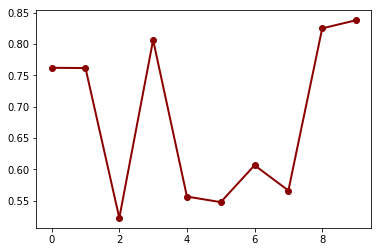

In [32]:
plt.plot(acc[method])

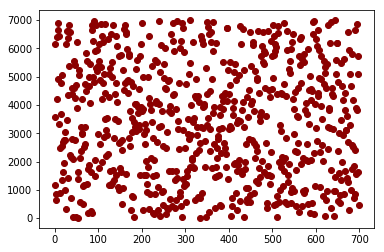

In [36]:
plt.scatter(range(len(training_choice)), training_choice)